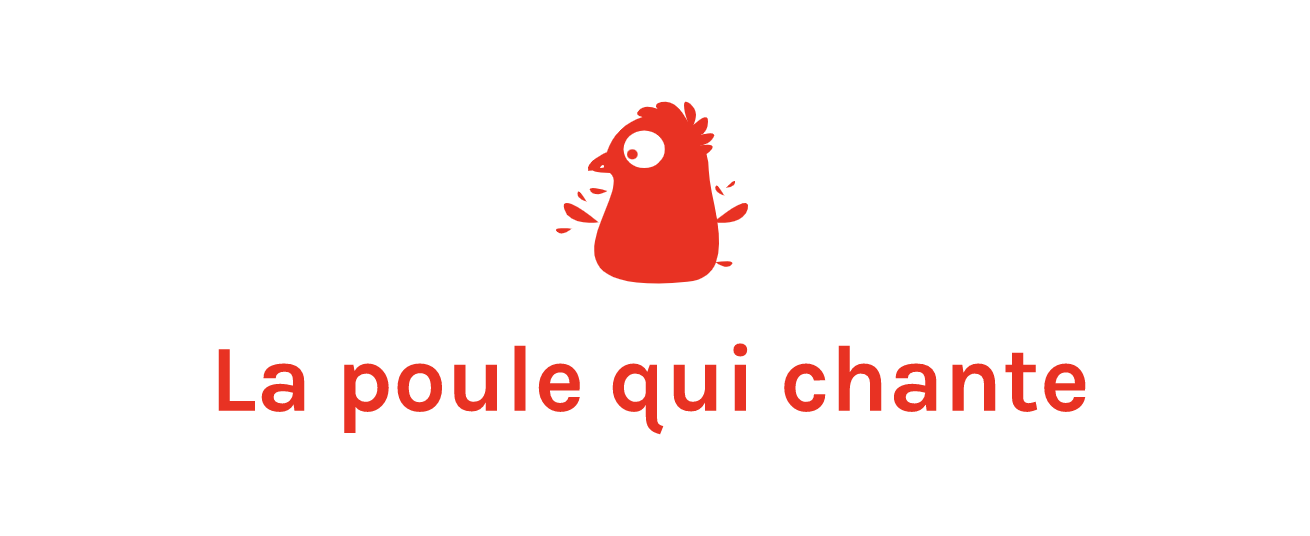

# <ins>Contexte</ins>  
Un client producteur de volaille souhaite trouver de nouveaux clients à l'international. Pour cela, il fait appel à nous pour lui faire une proposition des pays dans lesquelles il serait interessant d'exporter sa vollaile.

Afin de répondre à la demande du client, nous procèderons ainsi :
> Observer les données  
> Nettoyer les données  
> Réaliser une ACP  
> Définir des clusters avec K-means et la méthode de classification ascendante hierarchique

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from yellowbrick.cluster import KElbowVisualizer

from warnings import filterwarnings
filterwarnings('ignore')
sns.set()

# <span style='color:blue '>I. Data Preparation </span>

### 1) Import et observation des données

In [2]:
# Import des données initiales

alimentation = pd.read_csv("DisponibiliteAlimentaire_2017.csv")
population = pd.read_csv("Population_2000_2018.csv")

In [3]:
# Import de données supplémentaires

stab_politic = pd.read_csv("stabilité politique.csv")
stab_politique = stab_politic[['Zone', 'Valeur']]
stab_politique.rename(columns={'Valeur':'Stab_politique'}, inplace=True)
stab_politique

Zone  Stab_politique
0                               Afghanistan           -2.80
1                            Afrique du Sud           -0.28
2                                   Albanie            0.38
3                                   Algérie           -0.92
4                                 Allemagne            0.59
..                                      ...             ...
192  Venezuela (République bolivarienne du)           -1.27
193                                Viet Nam            0.23
194                                   Yémen           -2.94
195                                  Zambie            0.15
196                                Zimbabwe           -0.71

[197 rows x 2 columns]

In [4]:
# Import de données supplémentaires

pib_hab = pd.read_csv("pib_hab.csv")
pib_hab = pib_hab[["Zone", "Valeur"]]
pib_hab.rename(columns={"Valeur" : "PIB_hab"}, inplace=True)
pib_hab

Zone  PIB_hab
0       Afghanistan   2058.4
1    Afrique du Sud  13860.3
2           Albanie  12771.0
3           Algérie  11737.4
4         Allemagne  53071.5
..              ...      ...
182         Uruguay  23009.9
183         Vanuatu   3081.5
184        Viet Nam   8996.4
185          Zambie   3485.0
186        Zimbabwe   3795.6

[187 rows x 2 columns]

In [5]:
# Dimension des tableaux

print("\n""Dimensions de la table population")
print(population.shape)
print("\n""Dimensions de la table alimentation")
print(alimentation.shape)



Dimensions de la table population
(4411, 15)

Dimensions de la table alimentation
(176600, 14)


In [6]:
# Recherche de valeurs Null
print("\n""Valeur Null dans la table population""\n")
print(population.isna().sum())
print("\n""\n""Valeur Null dans la table alimentation""\n")
print(alimentation.isna().sum())


Valeur Null dans la table population

Code Domaine                 0
Domaine                      0
Code zone                    0
Zone                         0
Code Élément                 0
Élément                      0
Code Produit                 0
Produit                      0
Code année                   0
Année                        0
Unité                        0
Valeur                       0
Symbole                      0
Description du Symbole       0
Note                      4153
dtype: int64


Valeur Null dans la table alimentation

Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64


#### Seule la table population contient des valeurs nulles. Celles-ci seront retirées pour la suite de l'analyse

In [7]:
# Nbr de valeurs uniques par colonne
print("\n""Table population""\n")
print(population.nunique())
print("\n""Tables alimentation""\n")
print(alimentation.nunique())


Table population

Code Domaine                 1
Domaine                      1
Code zone                  238
Zone                       238
Code Élément                 1
Élément                      1
Code Produit                 1
Produit                      1
Code année                  19
Année                       19
Unité                        1
Valeur                    4398
Symbole                      2
Description du Symbole       2
Note                         1
dtype: int64

Tables alimentation

Code Domaine                 1
Domaine                      1
Code zone                  174
Zone                       174
Code Élément                17
Élément                     17
Code Produit                98
Produit                     98
Code année                   1
Année                        1
Unité                        4
Valeur                    7250
Symbole                      2
Description du Symbole       2
dtype: int64


### 2) Fusion des tables

In [8]:
# Jointure des tables

jointure = alimentation.merge(population, how='inner', on = ['Zone', "Année"], indicator=True)
jointure

Code Domaine_x                    Domaine_x  Code zone_x         Zone  \
0                 FBS  Nouveaux Bilans Alimentaire            2  Afghanistan   
1                 FBS  Nouveaux Bilans Alimentaire            2  Afghanistan   
2                 FBS  Nouveaux Bilans Alimentaire            2  Afghanistan   
3                 FBS  Nouveaux Bilans Alimentaire            2  Afghanistan   
4                 FBS  Nouveaux Bilans Alimentaire            2  Afghanistan   
...               ...                          ...          ...          ...   
176595            FBS  Nouveaux Bilans Alimentaire          181     Zimbabwe   
176596            FBS  Nouveaux Bilans Alimentaire          181     Zimbabwe   
176597            FBS  Nouveaux Bilans Alimentaire          181     Zimbabwe   
176598            FBS  Nouveaux Bilans Alimentaire          181     Zimbabwe   
176599            FBS  Nouveaux Bilans Alimentaire          181     Zimbabwe   

        Code Élément_x                                          Élément_x  \
0                 5511                                         Production   
1                 5611                            Importations - Quantité   
2                 5072                                 Variation de stock   
3                 5911                            Exportations - Quantité   
4                 5301                           Disponibilité intérieure   
...                ...                                                ...   
176595            5142                                         Nourriture   
176596             645  Disponibilité alimentaire en quantité (kg/pers...   
176597             664     Disponibilité alimentaire (Kcal/personne/jour)   
176598             674  Disponibilité de protéines en quantité (g/pers...   
176599             684  Disponibilité de matière grasse en quantité (g...   

        Code Produit_x        Produit_x  Code année_x  Année  ...  \
0                 2511  Blé et produits          2017   2017  ...   
1                 2511  Blé et produits          2017   2017  ...   
2                 2511  Blé et produits          2017   2017  ...   
3                 2511  Blé et produits          2017   2017  ...   
4                 2511  Blé et produits          2017   2017  ...   
...                ...              ...           ...    ...  ...   
176595            2899     Miscellanees          2017   2017  ...   
176596            2899     Miscellanees          2017   2017  ...   
176597            2899     Miscellanees          2017   2017  ...   
176598            2899     Miscellanees          2017   2017  ...   
176599            2899     Miscellanees          2017   2017  ...   

                Élément_y  Code Produit_y               Produit_y  \
0       Population totale            3010  Population-Estimations   
1       Population totale            3010  Population-Estimations   
2       Population totale            3010  Population-Estimations   
3       Population totale            3010  Population-Estimations   
4       Population totale            3010  Population-Estimations   
...                   ...             ...                     ...   
176595  Population totale            3010  Population-Estimations   
176596  Population totale            3010  Population-Estimations   
176597  Population totale            3010  Population-Estimations   
176598  Population totale            3010  Population-Estimations   
176599  Population totale            3010  Population-Estimations   

       Code année_y         Unité_y   Valeur_y  Symbole_y  \
0              2017  1000 personnes  36296.113          X   
1              2017  1000 personnes  36296.113          X   
2              2017  1000 personnes  36296.113          X   
3              2017  1000 personnes  36296.113          X   
4              2017  1000 personnes  36296.113          X   
...             ...             ...        ...        ...   
176595         2017  1000 personnes 

In [9]:
# Vérification de la jointure

jointure._merge.value_counts()

both          176600
left_only          0
right_only         0
Name: _merge, dtype: int64

In [10]:
# Taux de valeurs manquante

jointure.isna().mean()

Code Domaine_x              0.0
Domaine_x                   0.0
Code zone_x                 0.0
Zone                        0.0
Code Élément_x              0.0
Élément_x                   0.0
Code Produit_x              0.0
Produit_x                   0.0
Code année_x                0.0
Année                       0.0
Unité_x                     0.0
Valeur_x                    0.0
Symbole_x                   0.0
Description du Symbole_x    0.0
Code Domaine_y              0.0
Domaine_y                   0.0
Code zone_y                 0.0
Code Élément_y              0.0
Élément_y                   0.0
Code Produit_y              0.0
Produit_y                   0.0
Code année_y                0.0
Unité_y                     0.0
Valeur_y                    0.0
Symbole_y                   0.0
Description du Symbole_y    0.0
Note                        1.0
_merge                      0.0
dtype: float64

In [11]:
# Recherche de doublons

jointure.duplicated().sum()

0

### 3) Sélection des variables

#### Nous passons à l'étape où nous sélectionnons les variables que nous allons conserver pour la suite de l'analyse

In [12]:
# Sélection uniquement des produits 'Viande de volailles'

df_volaille = jointure[jointure["Produit_x"] == 'Viande de Volailles']
df_volaille

Code Domaine_x                    Domaine_x  Code zone_x         Zone  \
651               FBS  Nouveaux Bilans Alimentaire            2  Afghanistan   
652               FBS  Nouveaux Bilans Alimentaire            2  Afghanistan   
653               FBS  Nouveaux Bilans Alimentaire            2  Afghanistan   
654               FBS  Nouveaux Bilans Alimentaire            2  Afghanistan   
655               FBS  Nouveaux Bilans Alimentaire            2  Afghanistan   
...               ...                          ...          ...          ...   
176396            FBS  Nouveaux Bilans Alimentaire          181     Zimbabwe   
176397            FBS  Nouveaux Bilans Alimentaire          181     Zimbabwe   
176398            FBS  Nouveaux Bilans Alimentaire          181     Zimbabwe   
176399            FBS  Nouveaux Bilans Alimentaire          181     Zimbabwe   
176400            FBS  Nouveaux Bilans Alimentaire          181     Zimbabwe   

        Code Élément_x                                          Élément_x  \
651               5511                                         Production   
652               5611                            Importations - Quantité   
653               5072                                 Variation de stock   
654               5301                           Disponibilité intérieure   
655               5123                                             Pertes   
...                ...                                                ...   
176396            5142                                         Nourriture   
176397             645  Disponibilité alimentaire en quantité (kg/pers...   
176398             664     Disponibilité alimentaire (Kcal/personne/jour)   
176399             674  Disponibilité de protéines en quantité (g/pers...   
176400             684  Disponibilité de matière grasse en quantité (g...   

        Code Produit_x            Produit_x  Code année_x  Année  ...  \
651               2734  Viande de Volailles          2017   2017  ...   
652               2734  Viande de Volailles          2017   2017  ...   
653               2734  Viande de Volailles          2017   2017  ...   
654               2734  Viande de Volailles          2017   2017  ...   
655               2734  Viande de Volailles          2017   2017  ...   
...                ...                  ...           ...    ...  ...   
176396            2734  Viande de Volailles          2017   2017  ...   
176397            2734  Viande de Volailles          2017   2017  ...   
176398            2734  Viande de Volailles          2017   2017  ...   
176399            2734  Viande de Volailles          2017   2017  ...   
176400            2734  Viande de Volailles          2017   2017  ...   

                Élément_y  Code Produit_y               Produit_y  \
651     Population totale            3010  Population-Estimations   
652     Population totale            3010  Population-Estimations   
653     Population totale            3010  Population-Estimations   
654     Population totale            3010  Population-Estimations   
655     Population totale            3010  Population-Estimations   
...                   ...             ...                     ...   
176396  Population totale            3010  Population-Estimations   
176397  Population totale            3010  Population-Estimations   
176398  Population totale            3010  Population-Estimations   
176399  Population totale            3010  Population-Estimations   
176400  Population totale            3010  Population-Estimations   

       Code année_y         Unité_y   Valeur_y  Symbole_y  \
651            2017  1000 personnes  36296.113          X   
652            2017  1000 personnes  36296.113          X   
653            2017  1000 personnes  36296.113          X   
654            2017  1000 personnes  36296.113          X   
655            2017  1000 personnes  36296.113          X   
...             ...             ...        ...   

#### Dans la partie ci-dessous, nous retirons les variables n'ayant qu'une seule valeur.

In [13]:
# Recherche de variable contenant des valeurs uniques

df_volaille.nunique()

Code Domaine_x                1
Domaine_x                     1
Code zone_x                 172
Zone                        172
Code Élément_x               17
Élément_x                    17
Code Produit_x                1
Produit_x                     1
Code année_x                  1
Année                         1
Unité_x                       4
Valeur_x                    843
Symbole_x                     2
Description du Symbole_x      2
Code Domaine_y                1
Domaine_y                     1
Code zone_y                 172
Code Élément_y                1
Élément_y                     1
Code Produit_y                1
Produit_y                     1
Code année_y                  1
Unité_y                       1
Valeur_y                    172
Symbole_y                     1
Description du Symbole_y      1
Note                          0
_merge                        1
dtype: int64

In [14]:
# Le code ci-dessous nous permet de ne conserver que les colonnes ayant plus d'une valeur unique

col_nunique = df_volaille.nunique() > 1

# Nous enregistrons les noms des colonnes ayant plus d'une valeurs unique
df_col_nunique = list(col_nunique[col_nunique == True].index)
df_col_nunique

df_nunique = df_volaille[df_col_nunique]
df_nunique

Code zone_x         Zone  Code Élément_x  \
651               2  Afghanistan            5511   
652               2  Afghanistan            5611   
653               2  Afghanistan            5072   
654               2  Afghanistan            5301   
655               2  Afghanistan            5123   
...             ...          ...             ...   
176396          181     Zimbabwe            5142   
176397          181     Zimbabwe             645   
176398          181     Zimbabwe             664   
176399          181     Zimbabwe             674   
176400          181     Zimbabwe             684   

                                                Élément_x             Unité_x  \
651                                            Production  Milliers de tonnes   
652                               Importations - Quantité  Milliers de tonnes   
653                                    Variation de stock  Milliers de tonnes   
654                              Disponibilité intérieure  Milliers de tonnes   
655                                                Pertes  Milliers de tonnes   
...                                                   ...                 ...   
176396                                         Nourriture  Milliers de tonnes   
176397  Disponibilité alimentaire en quantité (kg/pers...                  kg   
176398     Disponibilité alimentaire (Kcal/personne/jour)  Kcal/personne/jour   
176399  Disponibilité de protéines en quantité (g/pers...     g/personne/jour   
176400  Disponibilité de matière grasse en quantité (g...     g/personne/jour   

        Valeur_x Symbole_x Description du Symbole_x  Code zone_y   Valeur_y  
651        28.00         S    Données standardisées            2  36296.113  
652        29.00         S    Données standardisées            2  36296.113  
653         0.00         S    Données standardisées            2  36296.113  
654        57.00         S    Données standardisées            2  36296.113  
655         2.00         S    Données standardisées            2  36296.113  
...          ...       ...                      ...          ...        ...  
176396     67.00         S    Données standardisées          181  14236.595  
176397      4.68        Fc          Donnée calculée          181  14236.595  
176398     16.00        Fc          Donnée calculée          181  14236.595  
176399      1.59        Fc          Donnée calculée          181  14236.595  
176400      0.99        Fc          Donnée calculée          181  14236.595  

[2061 rows x 10 columns]

### 4) Binarisation

#### Dans cette partie, nous nous interessons à la variable "Elément_x". En effet, celle-ci contient les différentes utilisations de la volaille dans l'ensemble des pays. Nous bianriserons aussi la colonne.

In [15]:
# Sélection des colonnes qui nous interesse avant la binarisation

df_nunique = df_nunique[['Zone', 'Valeur_y', 'Valeur_x', 'Élément_x', "Description du Symbole_x"]]
df_nunique

Zone   Valeur_y  Valeur_x  \
651     Afghanistan  36296.113     28.00   
652     Afghanistan  36296.113     29.00   
653     Afghanistan  36296.113      0.00   
654     Afghanistan  36296.113     57.00   
655     Afghanistan  36296.113      2.00   
...             ...        ...       ...   
176396     Zimbabwe  14236.595     67.00   
176397     Zimbabwe  14236.595      4.68   
176398     Zimbabwe  14236.595     16.00   
176399     Zimbabwe  14236.595      1.59   
176400     Zimbabwe  14236.595      0.99   

                                                Élément_x  \
651                                            Production   
652                               Importations - Quantité   
653                                    Variation de stock   
654                              Disponibilité intérieure   
655                                                Pertes   
...                                                   ...   
176396                                         Nourriture   
176397  Disponibilité alimentaire en quantité (kg/pers...   
176398     Disponibilité alimentaire (Kcal/personne/jour)   
176399  Disponibilité de protéines en quantité (g/pers...   
176400  Disponibilité de matière grasse en quantité (g...   

       Description du Symbole_x  
651       Données standardisées  
652       Données standardisées  
653       Données standardisées  
654       Données standardisées  
655       Données standardisées  
...                         ...  
176396    Données standardisées  
176397          Donnée calculée  
176398          Donnée calculée  
176399          Donnée calculée  
176400          Donnée calculée  

[2061 rows x 5 columns]

In [16]:
# Binarisation

df_bin = pd.get_dummies(df_nunique, columns=df_nunique.columns[3:], prefix='', prefix_sep='', drop_first=True)
df_bin

Zone   Valeur_y  Valeur_x  Aliments pour animaux  \
651     Afghanistan  36296.113     28.00                      0   
652     Afghanistan  36296.113     29.00                      0   
653     Afghanistan  36296.113      0.00                      0   
654     Afghanistan  36296.113     57.00                      0   
655     Afghanistan  36296.113      2.00                      0   
...             ...        ...       ...                    ...   
176396     Zimbabwe  14236.595     67.00                      0   
176397     Zimbabwe  14236.595      4.68                      0   
176398     Zimbabwe  14236.595     16.00                      0   
176399     Zimbabwe  14236.595      1.59                      0   
176400     Zimbabwe  14236.595      0.99                      0   

        Autres utilisations (non alimentaire)  \
651                                         0   
652                                         0   
653                                         0   
654                                         0   
655                                         0   
...                                       ...   
176396                                      0   
176397                                      0   
176398                                      0   
176399                                      0   
176400                                      0   

        Disponibilité alimentaire (Kcal/personne/jour)  \
651                                                  0   
652                                                  0   
653                                                  0   
654                                                  0   
655                                                  0   
...                                                ...   
176396                                               0   
176397                                               0   
176398                                               1   
176399                                               0   
176400                                               0   

        Disponibilité alimentaire en quantité (kg/personne/an)  \
651                                                     0        
652                                                     0        
653                                                     0        
654                                                     0        
655                                                     0        
...                                                   ...        
176396                                                  0        
176397                                                  1        
176398                                                  0        
176399                                                  0        
176400                                                  0        

        Disponibilité de matière grasse en quantité (g/personne/jour)  \
651                                                     0               
652                                                     0               
653                                                     0               
654                                                     0               
655                                                     0               
...                                                   ...               
176396                                                  0               
176397                                                  0               
176398                                                  0               
176399                                                  0               
176400                                                  1               

        Disponibilité de protéines en quantité (g/personne/jour)  \
651                                                     0          
652                                                     0          
653                                               

In [17]:
df_bin[df_bin['Aliments pour animaux'] == 1]

Zone   Valeur_y  Valeur_x  Aliments pour animaux  \
160384  Tchad  15016.753       0.0                      1   

        Autres utilisations (non alimentaire)  \
160384                                      0   

        Disponibilité alimentaire (Kcal/personne/jour)  \
160384                                               0   

        Disponibilité alimentaire en quantité (kg/personne/an)  \
160384                                                  0        

        Disponibilité de matière grasse en quantité (g/personne/jour)  \
160384                                                  0               

        Disponibilité de protéines en quantité (g/personne/jour)  \
160384                                                  0          

        Disponibilité intérieure  Exportations - Quantité  \
160384                         0                        0   

        Importations - Quantité  Nourriture  Pertes  Production  Résidus  \
160384                        0           0       0           0        0   

        Semences  Traitement  Variation de stock  Données standardisées  
160384         0           0                   0                      1

#### Nous pouvons observer que le Tchad est le seul pays utilisant de la viande de volaille comme "Aliment pour les animaux" 

In [18]:
# Nous multiplions toutes les colonnes par "Valeur_x" car elle contient la valeur pour chaque colonne où il y a un 1

for col in df_bin.columns[3:-1] :
    df_bin[col] = df_bin[col] * df_bin["Valeur_x"]
    

# Nous groupons à présent les lignes par pays afin d'obtenir une ligne pour 1 pays

df1 = df_bin.groupby(["Zone", "Valeur_y"]).sum().reset_index(level=-1)
df1

Valeur_y  Valeur_x  Aliments pour animaux  \
Zone                                                                 
Afghanistan             36296.113    178.40                    0.0   
Afrique du Sud          57009.756   6682.05                    0.0   
Albanie                  2884.169    263.07                    0.0   
Algérie                 41389.189    862.85                    0.0   
Allemagne               82658.409   6552.59                    0.0   
...                           ...       ...                    ...   
Émirats arabes unis      9487.203   1587.52                    0.0   
Équateur                16785.361   1135.81                    0.0   
États-Unis d'Amérique  325084.756  62650.44                    0.0   
Éthiopie               106399.924     44.20                    0.0   
Îles Salomon              636.039     40.27                    0.0   

                       Autres utilisations (non alimentaire)  \
Zone                                                           
Afghanistan                                              0.0   
Afrique du Sud                                           0.0   
Albanie                                                  0.0   
Algérie                                                  0.0   
Allemagne                                                0.0   
...                                                      ...   
Émirats arabes unis                                      0.0   
Équateur                                                 0.0   
États-Unis d'Amérique                                   89.0   
Éthiopie                                                 0.0   
Îles Salomon                                             0.0   

                       Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                                    
Afghanistan                                                       5.0   
Afrique du Sud                                                  143.0   
Albanie                                                          85.0   
Algérie                                                          22.0   
Allemagne                                                        71.0   
...                                                               ...   
Émirats arabes unis                                             147.0   
Équateur                                                         83.0   
États-Unis d'Amérique                                           219.0   
Éthiopie                                                          0.0   
Îles Salomon                                                     18.0   

                       Disponibilité alimentaire en quantité (kg/personne/an)  \
Zone                                                                            
Afghanistan                                                         1.53        
Afrique du Sud                                                     35.69        
Albanie                                                            16.36        
Algérie                                                             6.38        
Allemagne                                                          19.47        
...                                                                  ...        
Émirats arabes unis                                                43.47        
Équateur                                                           19.31        
États-Unis d'Amérique                                              55.68        
Éthiopie                                                            0.13        
Îles Salomon                                                        4.45        

                       Disponibilité de matière grasse en quantité (g/personne/jour)  \
Zone                                                                                   
Afghanistan                                                         0.33               
Afrique du Su

In [19]:
# Nous retirons toutes les colonnes qui ne seront pas pertinentes pour la suite de l'analyse

labels = ['Valeur_x',
          'Aliments pour animaux',
          'Autres utilisations (non alimentaire)',
          'Disponibilité intérieure',
          'Disponibilité alimentaire en quantité (kg/personne/an)',
          'Disponibilité alimentaire (Kcal/personne/jour)',
          'Disponibilité de matière grasse en quantité (g/personne/jour)',
          'Disponibilité de protéines en quantité (g/personne/jour)',
          'Résidus',
          'Semences',
          'Traitement',
          'Variation de stock',
          'Pertes',
          'Données standardisées']

df2 = df1.drop(columns=labels)
df2

Valeur_y  Exportations - Quantité  \
Zone                                                         
Afghanistan             36296.113                      0.0   
Afrique du Sud          57009.756                     63.0   
Albanie                  2884.169                      0.0   
Algérie                 41389.189                      0.0   
Allemagne               82658.409                    646.0   
...                           ...                      ...   
Émirats arabes unis      9487.203                     94.0   
Équateur                16785.361                      0.0   
États-Unis d'Amérique  325084.756                   3692.0   
Éthiopie               106399.924                      0.0   
Îles Salomon              636.039                      0.0   

                       Importations - Quantité  Nourriture  Production  
Zone                                                                    
Afghanistan                               29.0        55.0        28.0  
Afrique du Sud                           514.0      2035.0      1667.0  
Albanie                                   38.0        47.0        13.0  
Algérie                                    2.0       264.0       275.0  
Allemagne                                842.0      1609.0      1514.0  
...                                        ...         ...         ...  
Émirats arabes unis                      433.0       412.0        48.0  
Équateur                                   0.0       324.0       340.0  
États-Unis d'Amérique                    123.0     18100.0     21914.0  
Éthiopie                                   1.0        14.0        14.0  
Îles Salomon                               6.0         3.0         0.0  

[172 rows x 5 columns]

In [20]:
# Nous renommons les colonnes si nécéssaire

df2.rename(columns={'Valeur_y' : "Population"}, inplace=True)
df2

Population  Exportations - Quantité  \
Zone                                                         
Afghanistan             36296.113                      0.0   
Afrique du Sud          57009.756                     63.0   
Albanie                  2884.169                      0.0   
Algérie                 41389.189                      0.0   
Allemagne               82658.409                    646.0   
...                           ...                      ...   
Émirats arabes unis      9487.203                     94.0   
Équateur                16785.361                      0.0   
États-Unis d'Amérique  325084.756                   3692.0   
Éthiopie               106399.924                      0.0   
Îles Salomon              636.039                      0.0   

                       Importations - Quantité  Nourriture  Production  
Zone                                                                    
Afghanistan                               29.0        55.0        28.0  
Afrique du Sud                           514.0      2035.0      1667.0  
Albanie                                   38.0        47.0        13.0  
Algérie                                    2.0       264.0       275.0  
Allemagne                                842.0      1609.0      1514.0  
...                                        ...         ...         ...  
Émirats arabes unis                      433.0       412.0        48.0  
Équateur                                   0.0       324.0       340.0  
États-Unis d'Amérique                    123.0     18100.0     21914.0  
Éthiopie                                   1.0        14.0        14.0  
Îles Salomon                               6.0         3.0         0.0  

[172 rows x 5 columns]

In [21]:
# Rajout de la colonne 'pib_hab'
df2 = df2.merge(pib_hab, how='inner', on='Zone')

#Rajout de  la colonne 'stab_politique'
df2 = df2.merge(stab_politique, how='inner', on='Zone')
df2

Zone  Population  Exportations - Quantité  \
0              Afghanistan   36296.113                      0.0   
1           Afrique du Sud   57009.756                     63.0   
2                  Albanie    2884.169                      0.0   
3                  Algérie   41389.189                      0.0   
4                Allemagne   82658.409                    646.0   
..                     ...         ...                      ...   
159    Émirats arabes unis    9487.203                     94.0   
160               Équateur   16785.361                      0.0   
161  États-Unis d'Amérique  325084.756                   3692.0   
162               Éthiopie  106399.924                      0.0   
163           Îles Salomon     636.039                      0.0   

     Importations - Quantité  Nourriture  Production  PIB_hab  Stab_politique  
0                       29.0        55.0        28.0   2058.4           -2.80  
1                      514.0      2035.0      1667.0  13860.3           -0.28  
2                       38.0        47.0        13.0  12771.0            0.38  
3                        2.0       264.0       275.0  11737.4           -0.92  
4                      842.0      1609.0      1514.0  53071.5            0.59  
..                       ...         ...         ...      ...             ...  
159                    433.0       412.0        48.0  67183.6            0.62  
160                      0.0       324.0       340.0  11617.9           -0.07  
161                    123.0     18100.0     21914.0  59914.8            0.29  
162                      1.0        14.0        14.0   2021.6           -1.68  
163                      6.0         3.0         0.0   2663.5            0.20  

[164 rows x 8 columns]

In [22]:
df2 = df2.set_index('Zone')
df2.head()

Population  Exportations - Quantité  Importations - Quantité  \
Zone                                                                           
Afghanistan      36296.113                      0.0                     29.0   
Afrique du Sud   57009.756                     63.0                    514.0   
Albanie           2884.169                      0.0                     38.0   
Algérie          41389.189                      0.0                      2.0   
Allemagne        82658.409                    646.0                    842.0   

                Nourriture  Production  PIB_hab  Stab_politique  
Zone                                                             
Afghanistan           55.0        28.0   2058.4           -2.80  
Afrique du Sud      2035.0      1667.0  13860.3           -0.28  
Albanie               47.0        13.0  12771.0            0.38  
Algérie              264.0       275.0  11737.4           -0.92  
Allemagne           1609.0      1514.0  53071.5            0.59

In [23]:
# On conserve le noms des variables dans la variable "features"
features = df2.columns

# On conserve le noms des pays dans la variables "pays"
pays = df2.index

# <span style='color:blue '>II. Analyse en Composantes Principales </span>

### 1) Standardisation : Centrage/Réduction des données

In [24]:
# On ne conserve que les valeurs du tableau
X = df2.values
X

array([[ 3.62961130e+04,  0.00000000e+00,  2.90000000e+01, ...,
         2.80000000e+01,  2.05840000e+03, -2.80000000e+00],
       [ 5.70097560e+04,  6.30000000e+01,  5.14000000e+02, ...,
         1.66700000e+03,  1.38603000e+04, -2.80000000e-01],
       [ 2.88416900e+03,  0.00000000e+00,  3.80000000e+01, ...,
         1.30000000e+01,  1.27710000e+04,  3.80000000e-01],
       ...,
       [ 3.25084756e+05,  3.69200000e+03,  1.23000000e+02, ...,
         2.19140000e+04,  5.99148000e+04,  2.90000000e-01],
       [ 1.06399924e+05,  0.00000000e+00,  1.00000000e+00, ...,
         1.40000000e+01,  2.02160000e+03, -1.68000000e+00],
       [ 6.36039000e+02,  0.00000000e+00,  6.00000000e+00, ...,
         0.00000000e+00,  2.66350000e+03,  2.00000000e-01]])

In [25]:
# Standardisation
scaler = StandardScaler()

# Centrage / Réduction
X_scaled = scaler.fit_transform(X)

# Vérification de la moyenne et de l'écart-type
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5    6
mean -0.0 -0.0 -0.0 -0.0 -0.0 -0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0

### 2) Création et entrainement du modele PCA

In [26]:
# On instancie notre ACP
pca = PCA(n_components = 7)

# on l'entraine sur les données scalées
pca.fit(X_scaled)

PCA(n_components=7)

### 3) Projection des individus

In [27]:
# Nous transformons nos données pour la projection

X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-6.24749980e-01,  2.62749563e+00,  7.79809926e-01,
        -9.59812003e-01,  1.47303115e+00,  1.94527182e-01,
         1.17701768e-02],
       [ 1.08690839e+00, -1.97287138e-01,  1.90238759e+00,
        -9.20220602e-01, -6.94151552e-01, -5.37065414e-01,
        -2.57211644e-02],
       [-6.16934795e-01, -1.16276306e-01, -3.70496465e-01,
         2.70580347e-02, -4.62709551e-01, -1.95327143e-02,
        -9.38713094e-03],
       [-4.28946126e-01,  1.03577577e+00,  2.54717357e-02,
        -1.15046052e-01,  4.66535288e-01,  2.99877175e-03,
        -1.07410962e-03],
       [ 2.19212709e+00, -2.56853119e+00,  2.93338075e+00,
        -9.44558146e-01, -4.73332326e-01,  6.43660253e-01,
        -1.39866311e-02]])

Text(0.5, 1.0, "Projection des individus sur l'axe F1 et F2")

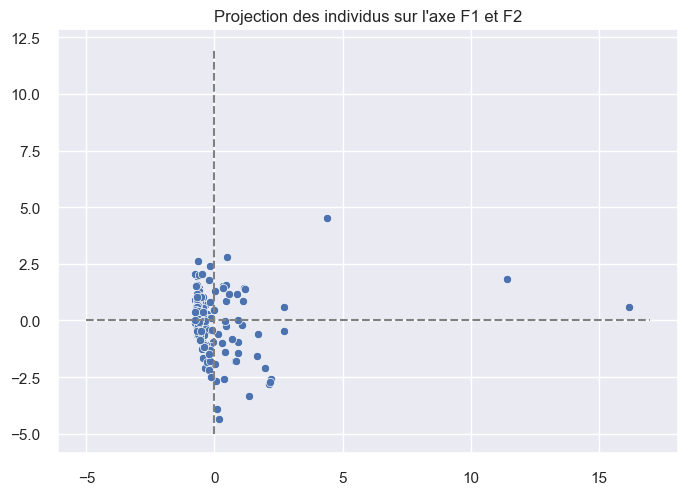

In [28]:
# Projection des individus sur les 2 premiers axes principaux

sns.scatterplot(x=X_proj[:,0], y=X_proj[:,1])
plt.plot([-5, 17], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-5, 12], color='grey', ls='--')
plt.title("Projection des individus sur l'axe F1 et F2")

#### Nous pouvons voir certains outliers présent sur notre graphe. Nous allons les extraires puis les analyser plus tard. Pour ce faire, nous utiliserons la IsolationForest

In [29]:
# Importation de la lirairie IsolationForest

from sklearn.ensemble import IsolationForest

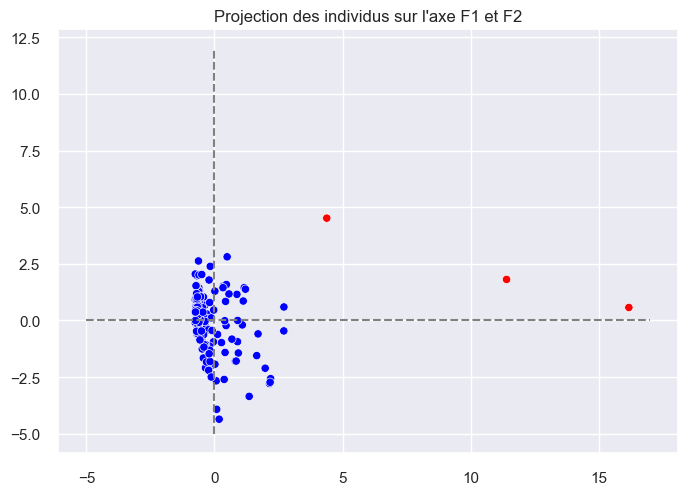

In [30]:
# Nous estimons à 3% la quantité de "valeurs abérantes dans le dataset"

model = IsolationForest(contamination=0.015)
model.fit(X_proj)
sns.scatterplot(x=X_proj[:,0], y=X_proj[:,1], hue=model.predict(X_proj), palette=["red", "blue"])
plt.plot([-5, 17], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-5, 12], color='grey', ls='--')
plt.legend([],[], frameon=False)
plt.title("Projection des individus sur l'axe F1 et F2");

#### La fonction IsolationForest nous a permis de distinguer 3 outliers. nous allons les extraire de notre table et poursuivre l'analyse

In [31]:
# On enregistre les outliers dans une variable

outliers = model.predict(X_proj) == -1
df_outliers = df2.loc[outliers]
df_outliers

Population  Exportations - Quantité  \
Zone                                                          
Brésil                  207833.823                   4223.0   
Inde                   1338676.785                      4.0   
États-Unis d'Amérique   325084.756                   3692.0   

                       Importations - Quantité  Nourriture  Production  \
Zone                                                                     
Brésil                                     3.0      9982.0     14201.0   
Inde                                       0.0      2965.0      3545.0   
États-Unis d'Amérique                    123.0     18100.0     21914.0   

                       PIB_hab  Stab_politique  
Zone                                            
Brésil                 14524.6           -0.47  
Inde                    6182.9           -0.76  
États-Unis d'Amérique  59914.8            0.29

In [32]:
# Création de la table df3 sans les outliers

df3 = df2.drop(index=df_outliers.index)
df3

Population  Exportations - Quantité  \
Zone                                                       
Afghanistan           36296.113                      0.0   
Afrique du Sud        57009.756                     63.0   
Albanie                2884.169                      0.0   
Algérie               41389.189                      0.0   
Allemagne             82658.409                    646.0   
...                         ...                      ...   
Égypte                96442.591                      1.0   
Émirats arabes unis    9487.203                     94.0   
Équateur              16785.361                      0.0   
Éthiopie             106399.924                      0.0   
Îles Salomon            636.039                      0.0   

                     Importations - Quantité  Nourriture  Production  PIB_hab  \
Zone                                                                            
Afghanistan                             29.0        55.0        28.0   2058.4   
Afrique du Sud                         514.0      2035.0      1667.0  13860.3   
Albanie                                 38.0        47.0        13.0  12771.0   
Algérie                                  2.0       264.0       275.0  11737.4   
Allemagne                              842.0      1609.0      1514.0  53071.5   
...                                      ...         ...         ...      ...   
Égypte                                 110.0      1250.0      1118.0  11014.5   
Émirats arabes unis                    433.0       412.0        48.0  67183.6   
Équateur                                 0.0       324.0       340.0  11617.9   
Éthiopie                                 1.0        14.0        14.0   2021.6   
Îles Salomon                             6.0         3.0         0.0   2663.5   

                     Stab_politique  
Zone                                 
Afghanistan                   -2.80  
Afrique du Sud                -0.28  
Albanie                        0.38  
Algérie                       -0.92  
Allemagne                      0.59  
...                             ...  
Égypte                        -1.42  
Émirats arabes unis            0.62  
Équateur                      -0.07  
Éthiopie                      -1.68  
Îles Salomon                   0.20  

[161 rows x 7 columns]

#### Nous entrainons nos nouvelles données dans le PCA

In [33]:
# Récupération des valeurs de df3

X = df3.values
X

array([[ 3.62961130e+04,  0.00000000e+00,  2.90000000e+01, ...,
         2.80000000e+01,  2.05840000e+03, -2.80000000e+00],
       [ 5.70097560e+04,  6.30000000e+01,  5.14000000e+02, ...,
         1.66700000e+03,  1.38603000e+04, -2.80000000e-01],
       [ 2.88416900e+03,  0.00000000e+00,  3.80000000e+01, ...,
         1.30000000e+01,  1.27710000e+04,  3.80000000e-01],
       ...,
       [ 1.67853610e+04,  0.00000000e+00,  0.00000000e+00, ...,
         3.40000000e+02,  1.16179000e+04, -7.00000000e-02],
       [ 1.06399924e+05,  0.00000000e+00,  1.00000000e+00, ...,
         1.40000000e+01,  2.02160000e+03, -1.68000000e+00],
       [ 6.36039000e+02,  0.00000000e+00,  6.00000000e+00, ...,
         0.00000000e+00,  2.66350000e+03,  2.00000000e-01]])

In [34]:
# Standardisation
scaler = StandardScaler()

# Centrage / Réduction
X_scaled = scaler.fit_transform(X)

# Vérification de la moyenne et de l'écart-type
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5    6
mean -0.0 -0.0 -0.0 -0.0  0.0  0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [35]:
# On instancie notre ACP
pca = PCA()

# on l'entraine sur les données scalées
pca.fit(X_scaled)

PCA()

In [36]:
# Nous transformons nos données pour la projection

X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-4.59317104e-01, -2.65207431e+00,  1.17688191e+00,
        -5.19413324e-01,  1.15539341e+00, -1.07272591e+00,
         5.97980905e-02],
       [ 3.44110348e+00, -3.57309047e-01, -4.35933456e-01,
        -1.29353742e+00, -1.00635736e+00, -2.38999932e-01,
        -7.75056159e-02],
       [-1.04350768e+00,  1.67764357e-01, -7.04077085e-02,
        -1.04140604e-01, -3.83301608e-01,  2.18895246e-01,
        -1.89208515e-02],
       [-2.39258738e-01, -1.17909888e+00,  1.20746709e-01,
         8.21977489e-02,  4.61304607e-01, -1.41809024e-01,
        -1.36834685e-03],
       [ 5.04051445e+00,  2.62218638e+00,  1.66466515e+00,
        -1.22694610e+00,  3.14779582e-01,  7.65359898e-01,
        -4.06616402e-02]])

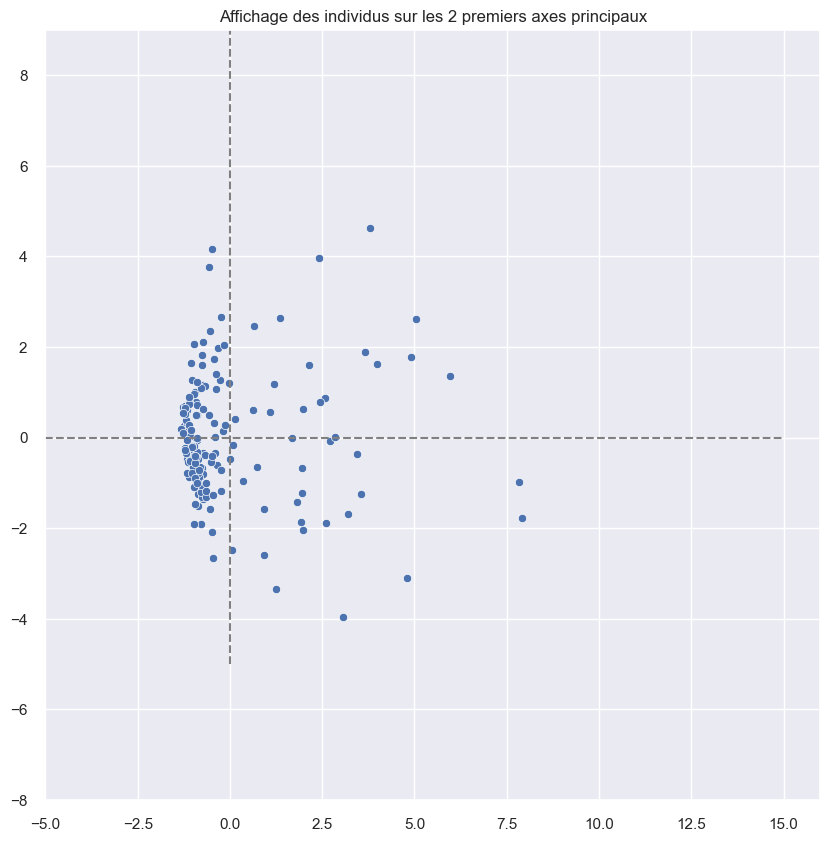

In [89]:
# Affichage des individus sur les 2 premiers axes principaux

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1])
ax.set_xlim(left=-5, right=16)
ax.set_ylim(bottom= -8, top=9)
plt.plot([-5, 15], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-5, 12], color='grey', ls='--')
ax.set_title("Affichage des individus sur les 2 premiers axes principaux")
#for i, (x, y) in enumerate(zip(X_proj[:, 0], X_proj[:, 1])) :
#    plt.text(x, y, df3.index[i])
plt.show()

In [38]:
# Intéressons nous maintenant à la variance captée par chaque nouvelle composante.
pca.explained_variance_ratio_

array([0.43964512, 0.26999095, 0.10857405, 0.07742536, 0.06080892,
       0.04179133, 0.00176428])

In [39]:
# On enregistre nos variances dans une nouvelle variable
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([43.96, 27.  , 10.86,  7.74,  6.08,  4.18,  0.18])

### 4) Eboulis des valeurs propres

In [40]:
# Somme cumulée

scree_cum = scree.cumsum().round()
scree_cum

array([ 44.,  71.,  82.,  90.,  96., 100., 100.])

In [41]:
x_list = range(1, 8)
list(x_list)

[1, 2, 3, 4, 5, 6, 7]

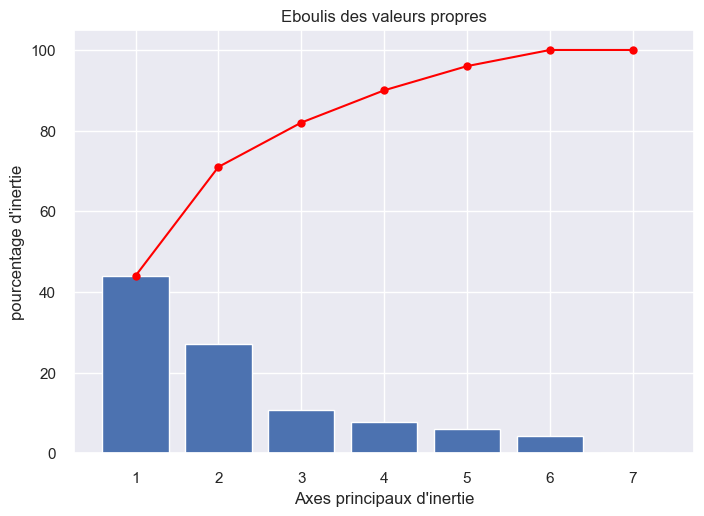

In [42]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker='o')
plt.xlabel("Axes principaux d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

#### Nous avons, dès le 5ème axe d'inertie, 96% de l'information totale du jeu dans l'espece multidimensionnel

In [43]:
n_components = 5

# On instancie notre ACP
pca = PCA(n_components=n_components)

# on l'entraine sur les données scalées
pca.fit(X_scaled)

PCA(n_components=5)

### 5) Analyse des variables sur les axes principaux d'inertie

In [44]:
# On enregistre les valeurs de nos variables

pcs = pca.components_

# Mise en format table

pcs = pd.DataFrame(pcs)
pcs

0         1         2         3         4         5         6
0  0.416059  0.286236  0.394019  0.532216  0.529321  0.137299 -0.086186
1 -0.330617  0.307193  0.238257 -0.076742 -0.060378  0.593669  0.614476
2 -0.172391  0.802843  0.182745 -0.272149 -0.146877 -0.273667 -0.348995
3  0.128553  0.374629 -0.842699  0.000684  0.320064  0.100831  0.142748
4  0.497035  0.001255 -0.032322 -0.291176 -0.306405  0.639630 -0.405112

In [45]:
x_list = range(1, 6)
list(x_list)

[1, 2, 3, 4, 5]

In [46]:
# Rajout des index et noms des colonnes

pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

Population  Exportations - Quantité  Importations - Quantité  Nourriture  \
F1        0.42                     0.29                     0.39        0.53   
F2       -0.33                     0.31                     0.24       -0.08   
F3       -0.17                     0.80                     0.18       -0.27   
F4        0.13                     0.37                    -0.84        0.00   
F5        0.50                     0.00                    -0.03       -0.29   

    Production  PIB_hab  Stab_politique  
F1        0.53     0.14           -0.09  
F2       -0.06     0.59            0.61  
F3       -0.15    -0.27           -0.35  
F4        0.32     0.10            0.14  
F5       -0.31     0.64           -0.41

Text(0.5, 1.0, "Analyse des variables sur les axes principaux d'inertie")

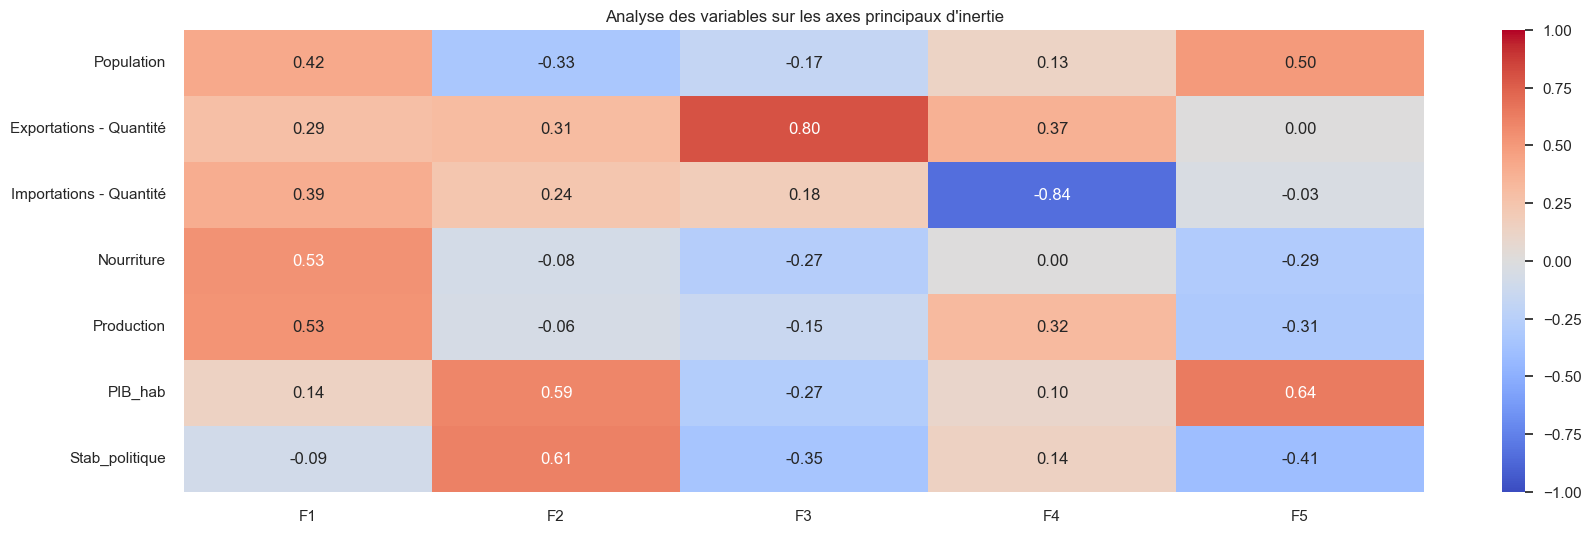

In [88]:
# Meilleure lisibilité

fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
ax.set_title("Analyse des variables sur les axes principaux d'inertie")

Description

- Les variables les mieux représentées sur l'axe F1 sont "Nourriture", "Production" et "Population"
- Les variables les mieux représentées sur l'axe F2 sont "PIB_hab", "Stab_politique"

In [48]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(20, 20))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.05,
                head_length=0.05, 
                width=0.015, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i],
                size=25)
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # Affichage des axes dans le titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

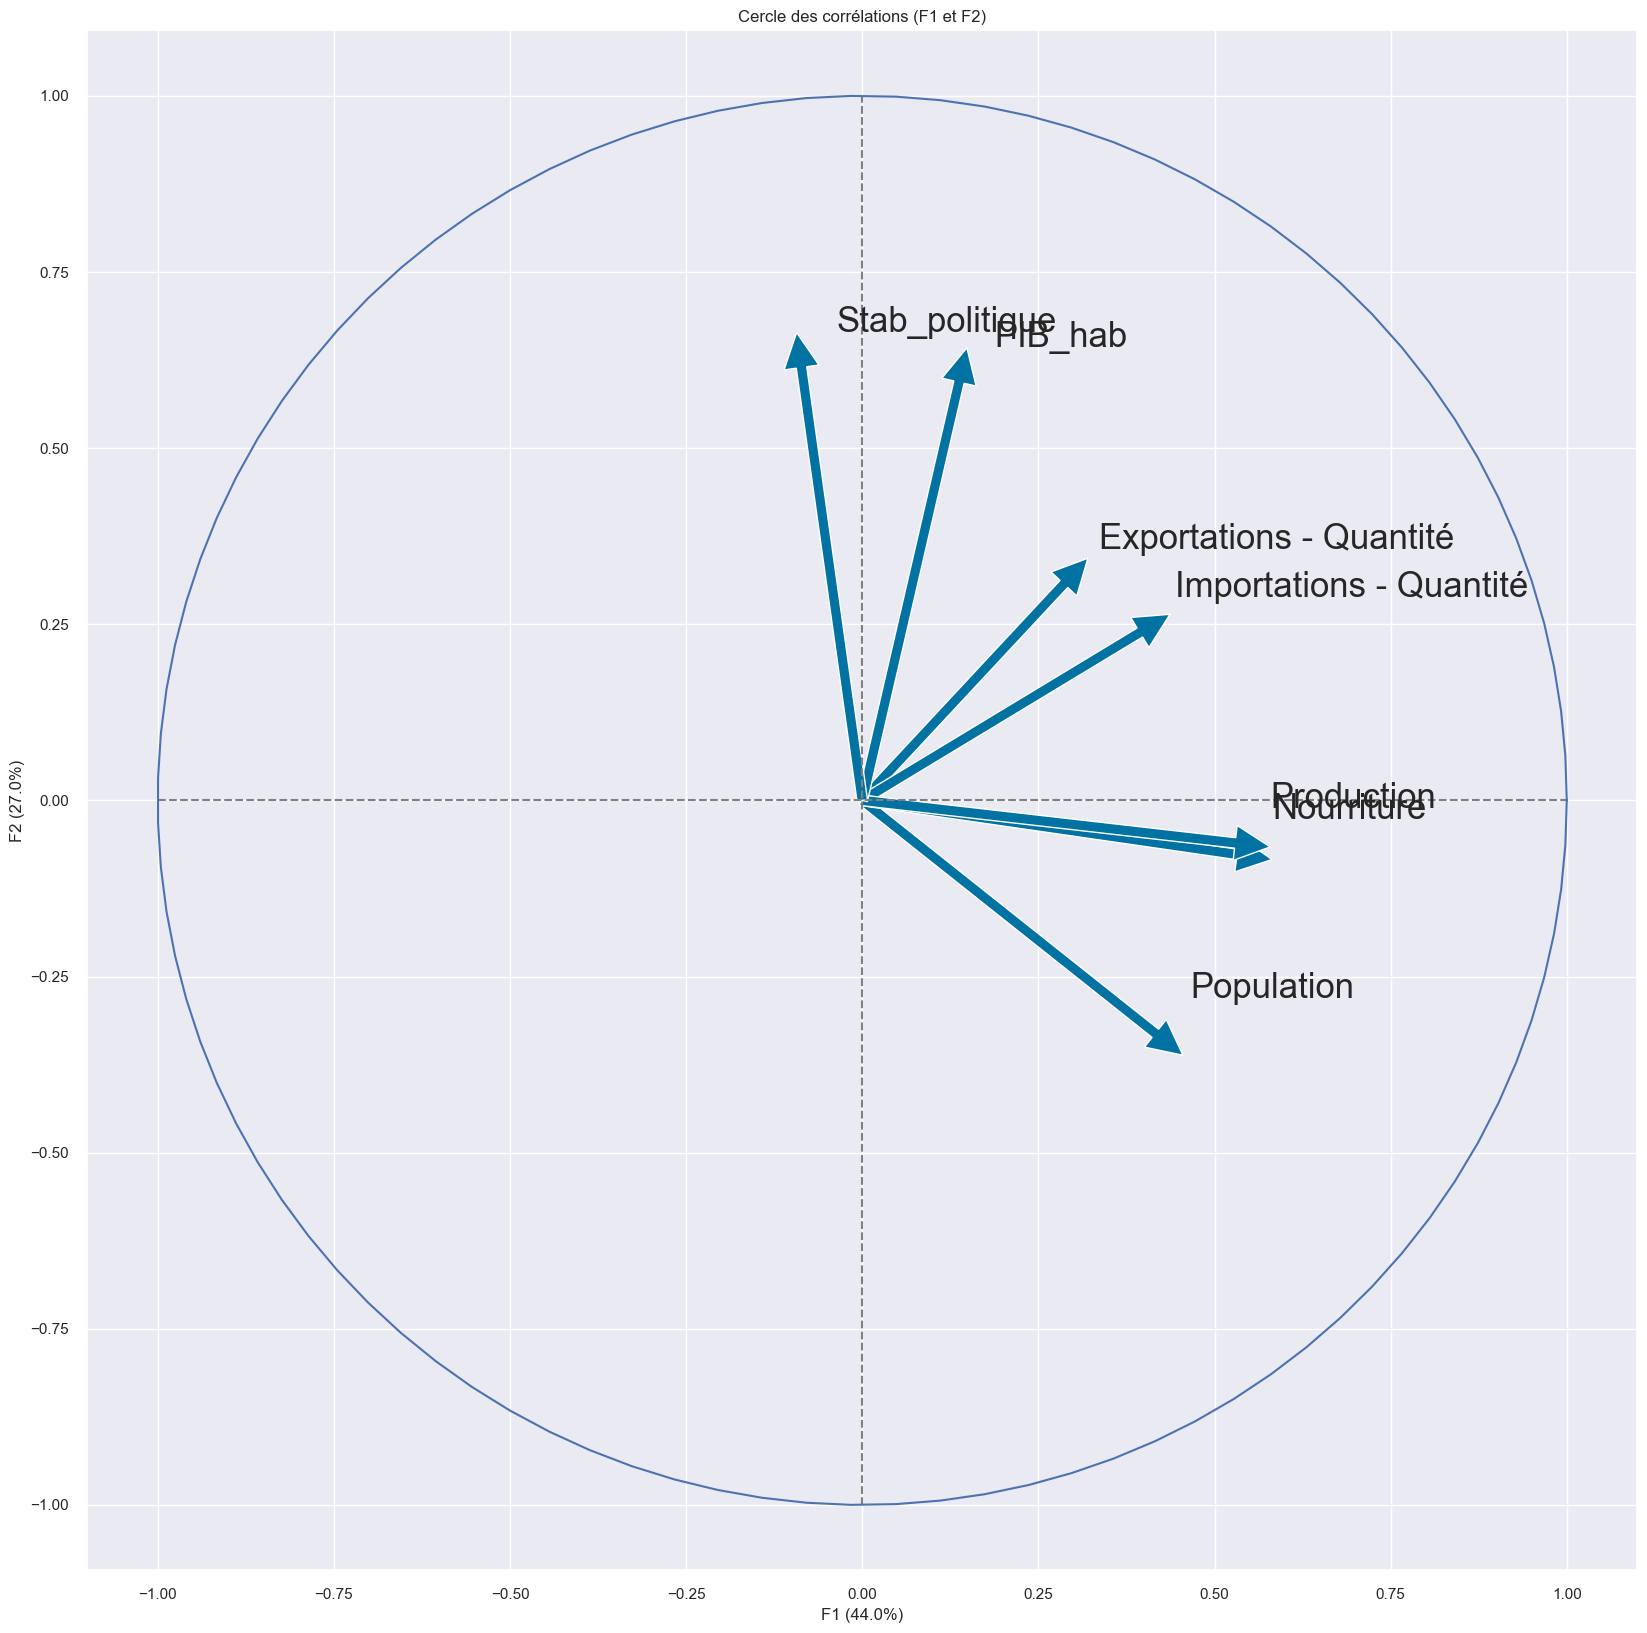

In [49]:
# Nous definissons les axes sur lesquels nous souhaitons projeter nos variables

x_y = (0,1)
correlation_graph(pca, x_y, features)

### Observation

- Ce premier plan composé de F1 et F2 nous permet de capter 71% de l'information totale du dataset.

- Nous pouvons constater que la quasi-totalité des variables sont positives sur l'axe F1.

- Nous observons que les variables "Nourriture" et "Production" sont très corrélées entre elles. De plus elles sont bien représentées sur l'axe F1.

- Les Variables "Stab_politique" et "PIB_hab" sont bien représenté sur l'axe F2.

- Nous observons que la variable "Population" est anti-corrélée à l'axe F2.

- Enfin, nous remarquons que des variables telles que "Importation" ou "Exportation" contribuent toutes 2 à F1 et F2 

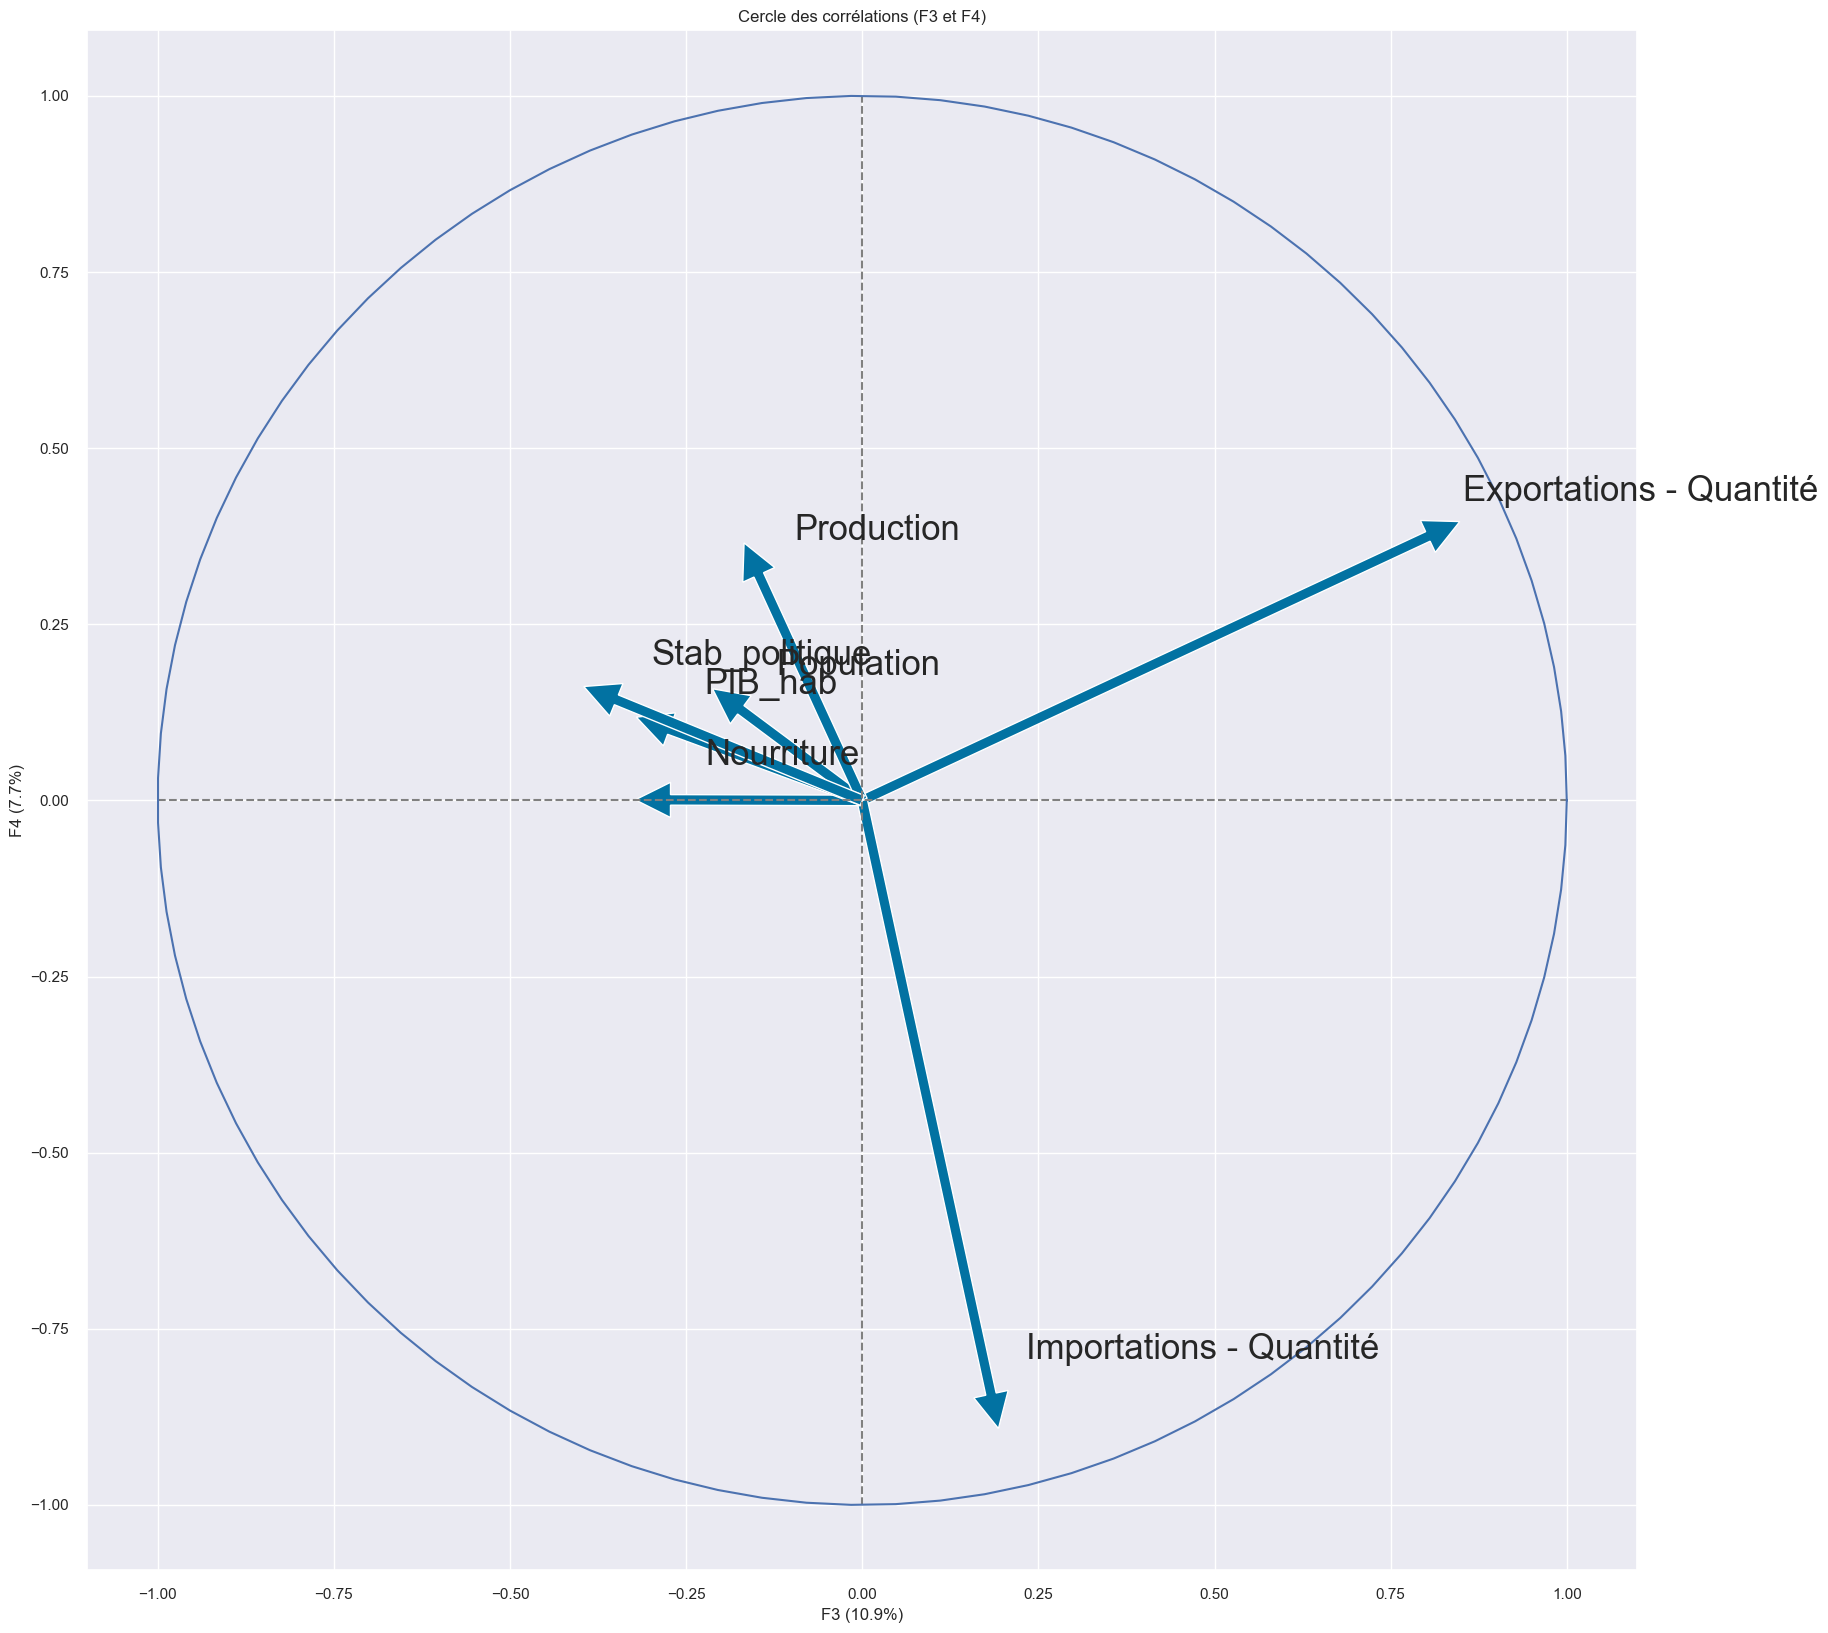

In [50]:
# Affichage des variables sur le plan F3 et F4
x_y = (2,3)
correlation_graph(pca, x_y, features)

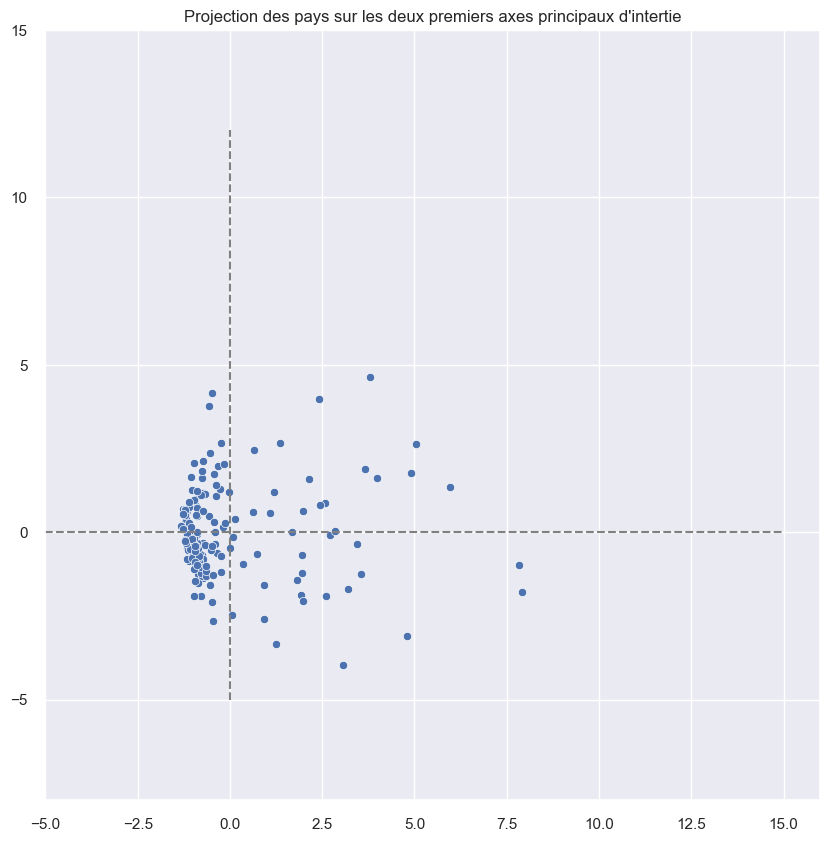

In [87]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1])
ax.set_xlim(left=-5, right=16)
ax.set_ylim(bottom= -8, top=15)
plt.plot([-5, 15], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-5, 12], color='grey', ls='--')
ax.set_title("Projection des pays sur les deux premiers axes principaux d'intertie")
#for i, (x, y) in enumerate(zip(X_proj[:, 2], X_proj[:, 3])) :
#    plt.text(x, y, df3.index[i])
plt.show()

# <span style='color:blue '>III. Définition des clusters </span>

### 1) Définition du nombre de clusters

Nous allons tenter de déterminer le nombre de cluster idéale. Pour se faire, nous allons utiliser la méthode dite de coude

In [52]:
# Import de la librairie Kmeans
from sklearn.cluster import KMeans

### La méthode du coude

In [53]:
# Définition d'une liste vide pour stocker les inerties
intertia = []

# Définition du nombre de cluster à tester
k_list = range(1, 10)
list(k_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [54]:
# Pour chaque valeur de k, on entraine un k-means spécifique et on stocke son inertie
for i in k_list :
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_proj)
    intertia.append(kmeans.inertia_)

intertia

[1127.0,
 746.5079776705946,
 611.2947280876871,
 494.61265228540395,
 417.64099046878454,
 360.2197037113508,
 318.5921652486057,
 274.7610568006649,
 257.3370118956541]

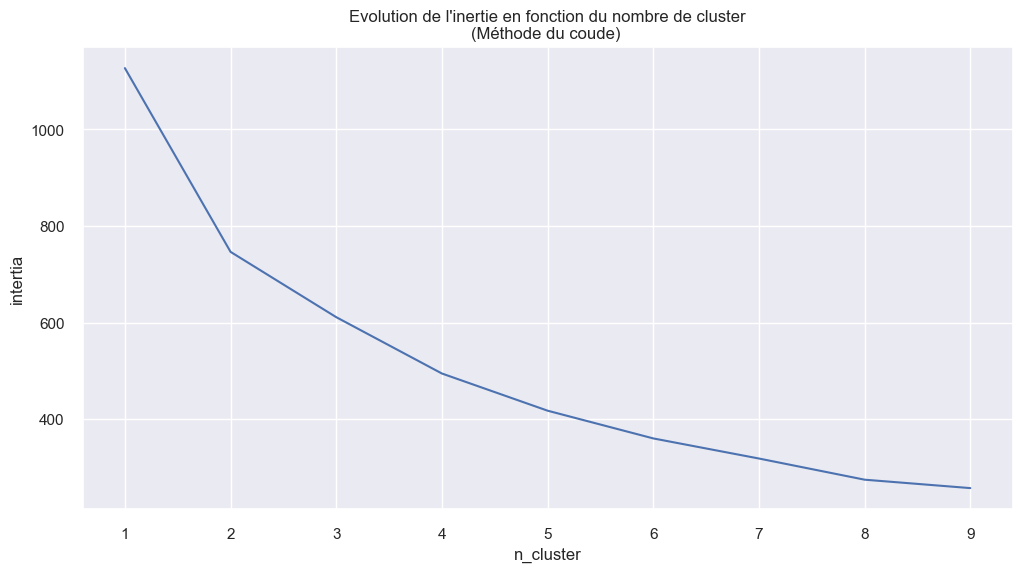

In [84]:
# Affichage des inerties sur graphique (Méthode du coude)

fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax.set_title("Evolution de l'inertie en fonction du nombre de cluster\n(Méthode du coude) ")
ax = plt.plot(k_list, intertia)

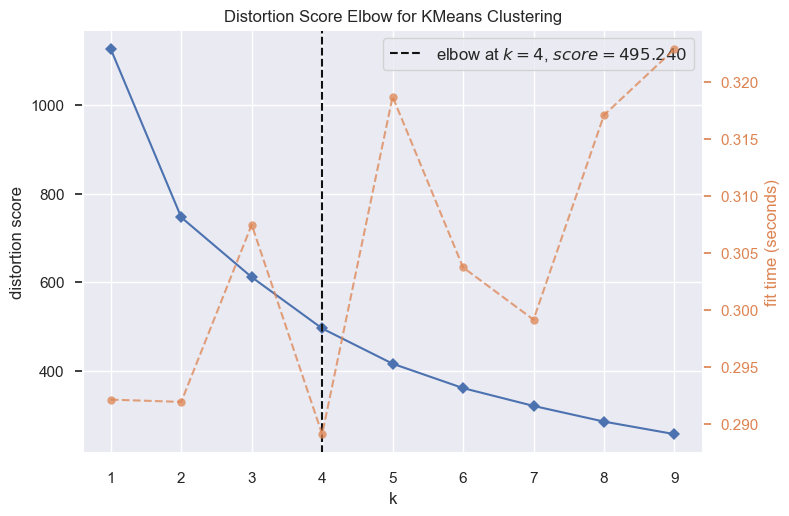

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
# 2nd méthode de recherche de nombre de cluster optimal

visualizer = KElbowVisualizer(kmeans, k = (1, 10))
visualizer.fit(X_proj)
visualizer.show()

### 1) Méthode du Kmeans

In [57]:
# Initialisation et exécution du Kmeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(X_proj)

KMeans(n_clusters=4)

In [58]:
# Affichage des labels

k_labels = kmeans.labels_
k_labels 

array([0, 2, 0, 0, 3, 0, 1, 2, 2, 0, 1, 1, 0, 1, 0, 1, 3, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 2, 1, 3, 1, 1, 2, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1,
       0, 1, 1, 3, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1,
       1, 0, 2, 0, 2, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0,
       0, 1, 0, 1, 0, 2, 1, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1,
       0, 3, 2, 3, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 3, 0, 0, 1, 0, 0, 2, 2, 1, 0, 2,
       0, 0, 2, 1, 0, 0, 0])

In [59]:
# Projection 3D des clusters

import plotly.express as px
fig = px.scatter_3d(df3,
                    x=X_proj[:, 0],
                    y=X_proj[:, 1],
                    z=X_proj[:, 2], 
                    color=k_labels, 
                    opacity=0.5, 
                    color_continuous_scale=["red", 'blue', 'green', "yellow"])
fig.show()

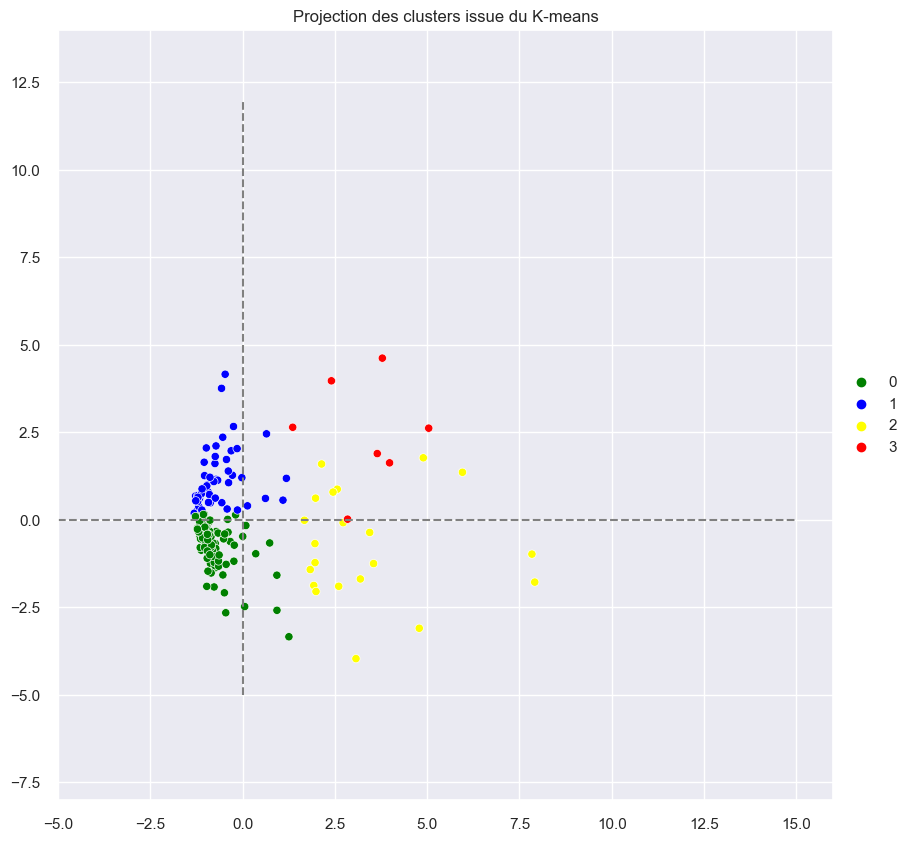

In [82]:
# Projection 2D sur les axes principaux des clusters

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=k_labels, palette=["green", 'blue', 'yellow', 'red'])
ax.set_xlim(left=-5, right=16)
ax.set_ylim(bottom= -8, top=14)
ax.legend(loc='right', bbox_to_anchor=(1.1, 0.5), ncol=1)
plt.plot([-5, 15], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-5, 12], color='grey', ls='--')
ax.set_title("Projection des clusters issue du K-means")
#for i, (x, y) in enumerate(zip(X_proj[:, 0], X_proj[:, 1])) :
#    plt.text(x, y, df3.index[i])
plt.show()

### 3) La classification ascendante hierarchique

In [61]:
from scipy.cluster.hierarchy import dendrogram, linkage

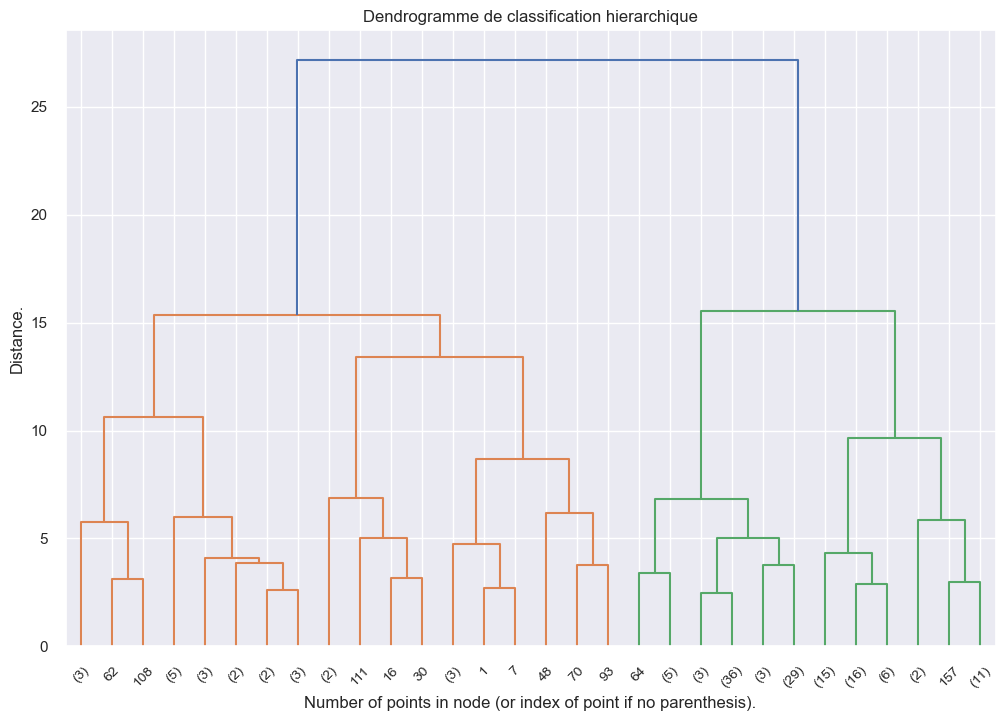

In [62]:
# Affichage du dendrogramme des clusters

Z = linkage(X_proj, method="ward")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

_ = dendrogram(Z, truncate_mode="lastp", ax=ax)

plt.title("Dendrogramme de classification hierarchique")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

In [63]:
from sklearn.cluster import AgglomerativeClustering

In [64]:
# Initialisation du clustering ascendant hiérarchique

cah = AgglomerativeClustering(n_clusters=4, linkage="ward")

cah.fit(X_proj)

AgglomerativeClustering(n_clusters=4)

In [65]:
# Affichage des clusters

cah.labels_

array([2, 0, 2, 2, 0, 2, 3, 0, 1, 2, 1, 3, 2, 3, 1, 3, 0, 2, 2, 2, 3, 3,
       2, 2, 2, 3, 2, 2, 1, 3, 0, 3, 3, 1, 2, 3, 3, 2, 3, 2, 3, 2, 1, 3,
       2, 3, 3, 0, 0, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 2, 3,
       3, 2, 1, 2, 0, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 3, 3, 2, 2, 1, 2, 2,
       2, 3, 2, 3, 2, 0, 3, 2, 2, 1, 3, 2, 2, 1, 3, 3, 2, 3, 2, 2, 1, 3,
       2, 0, 1, 0, 3, 2, 3, 0, 2, 2, 1, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2,
       3, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 0, 2, 2, 3, 2, 2, 1, 1, 3, 3, 1,
       2, 2, 1, 3, 2, 1, 2], dtype=int64)

In [66]:
# Projection 3D des clusters issue de la classification ascendante hierarchique

fig = px.scatter_3d(df3,
                    x=X_proj[:, 0],
                    y=X_proj[:, 1],
                    z=X_proj[:, 2], 
                    color=cah.labels_, 
                    opacity=0.5, 
                    color_continuous_scale=["red", 'yellow', 'blue', "green"])
fig.show()

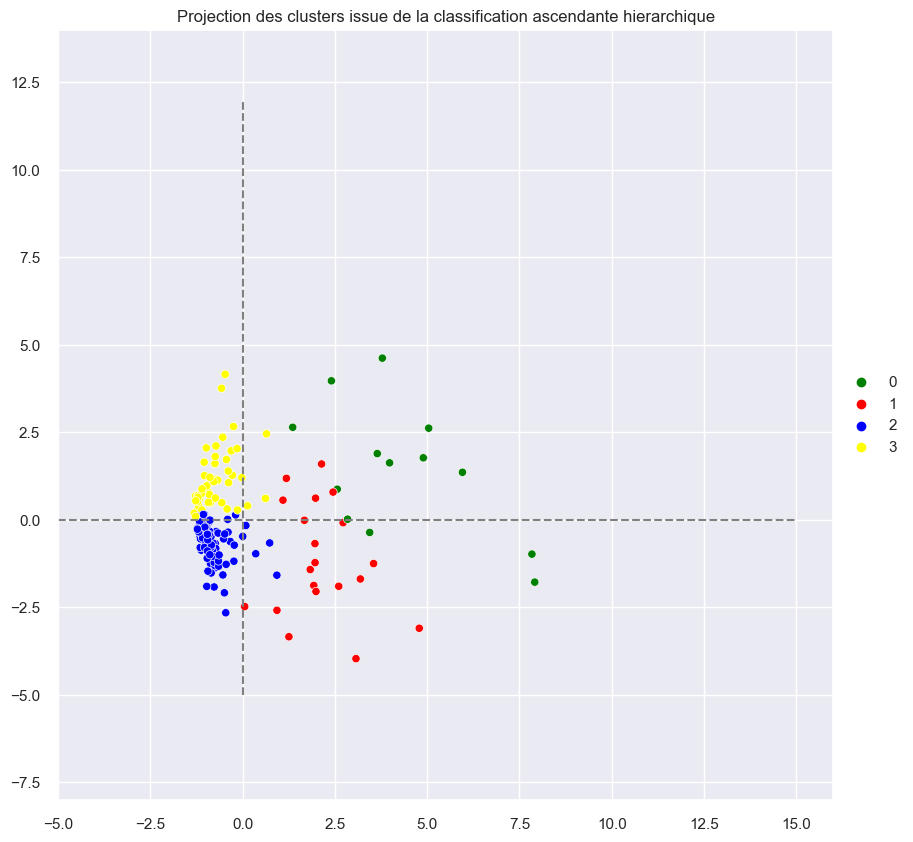

In [81]:
# Projection 2D des clusters issue de la classification ascendante hierarchique

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=cah.labels_, palette=["green", 'red', 'blue', 'yellow'])
ax.set_xlim(left=-5, right=16)
ax.set_ylim(bottom= -8, top=14)
ax.legend(loc='right', bbox_to_anchor=(1.1, 0.5), ncol=1)
plt.plot([-5, 15], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-5, 12], color='grey', ls='--')
ax.set_title("Projection des clusters issue de la classification ascendante hierarchique")
#for i, (x, y) in enumerate(zip(X_proj[:, 0], X_proj[:, 1])) :
#    plt.text(x, y, df3.index[i])
plt.show()

# <span style='color:blue '>IV. Analyse des clusters </span>

## 1) Observation des clusters

In [68]:
# Insertion des clusters dans la table DF3

df3["Kmeans"] = k_labels
df3["CAH"] = cah.labels_
df3

Population  Exportations - Quantité  \
Zone                                                       
Afghanistan           36296.113                      0.0   
Afrique du Sud        57009.756                     63.0   
Albanie                2884.169                      0.0   
Algérie               41389.189                      0.0   
Allemagne             82658.409                    646.0   
...                         ...                      ...   
Égypte                96442.591                      1.0   
Émirats arabes unis    9487.203                     94.0   
Équateur              16785.361                      0.0   
Éthiopie             106399.924                      0.0   
Îles Salomon            636.039                      0.0   

                     Importations - Quantité  Nourriture  Production  PIB_hab  \
Zone                                                                            
Afghanistan                             29.0        55.0        28.0   2058.4   
Afrique du Sud                         514.0      2035.0      1667.0  13860.3   
Albanie                                 38.0        47.0        13.0  12771.0   
Algérie                                  2.0       264.0       275.0  11737.4   
Allemagne                              842.0      1609.0      1514.0  53071.5   
...                                      ...         ...         ...      ...   
Égypte                                 110.0      1250.0      1118.0  11014.5   
Émirats arabes unis                    433.0       412.0        48.0  67183.6   
Équateur                                 0.0       324.0       340.0  11617.9   
Éthiopie                                 1.0        14.0        14.0   2021.6   
Îles Salomon                             6.0         3.0         0.0   2663.5   

                     Stab_politique  Kmeans  CAH  
Zone                                              
Afghanistan                   -2.80       0    2  
Afrique du Sud                -0.28       2    0  
Albanie                        0.38       0    2  
Algérie                       -0.92       0    2  
Allemagne                      0.59       3    0  
...                             ...     ...  ...  
Égypte                        -1.42       2    1  
Émirats arabes unis            0.62       1    3  
Équateur                      -0.07       0    2  
Éthiopie                      -1.68       0    1  
Îles Salomon                   0.20       0    2  

[161 rows x 9 columns]

In [69]:
# Affichage des centroides du Kmeans

df3.groupby("Kmeans").mean().round(2)

Population  Exportations - Quantité  Importations - Quantité  \
Kmeans                                                                 
0         18740.30                     2.79                    28.81   
1          5739.77                    24.60                    52.77   
2         88147.01                   101.52                   271.71   
3         41487.33                   815.00                   465.43   

        Nourriture  Production   PIB_hab  Stab_politique   CAH  
Kmeans                                                          
0           113.02      108.46   7537.19           -0.51  1.98  
1           140.81      133.63  35424.31            0.81  2.92  
2          1842.05     1801.43  23453.75           -0.51  0.71  
3           860.14     1268.29  44358.46            0.40  0.00

In [70]:
# Affichage des centroides de la classification ascendante hiérarchique

cluster_CAH = df3.groupby("CAH").mean().round(2)
cluster_CAH

Population  Exportations - Quantité  Importations - Quantité  Nourriture  \
CAH                                                                             
0      65004.60                   482.38                   580.00     1734.46   
1      91453.92                    80.70                    78.90     1231.35   
2      13775.58                     2.94                    30.25      113.06   
3       4373.97                    24.14                    50.88      103.92   

     Production   PIB_hab  Stab_politique  Kmeans  
CAH                                                
0       1760.23  38856.92            0.15    2.54  
1       1319.80  19968.02           -0.67    1.60  
2        108.05   7731.48           -0.48    0.00  
3         94.96  34427.25            0.82    0.98

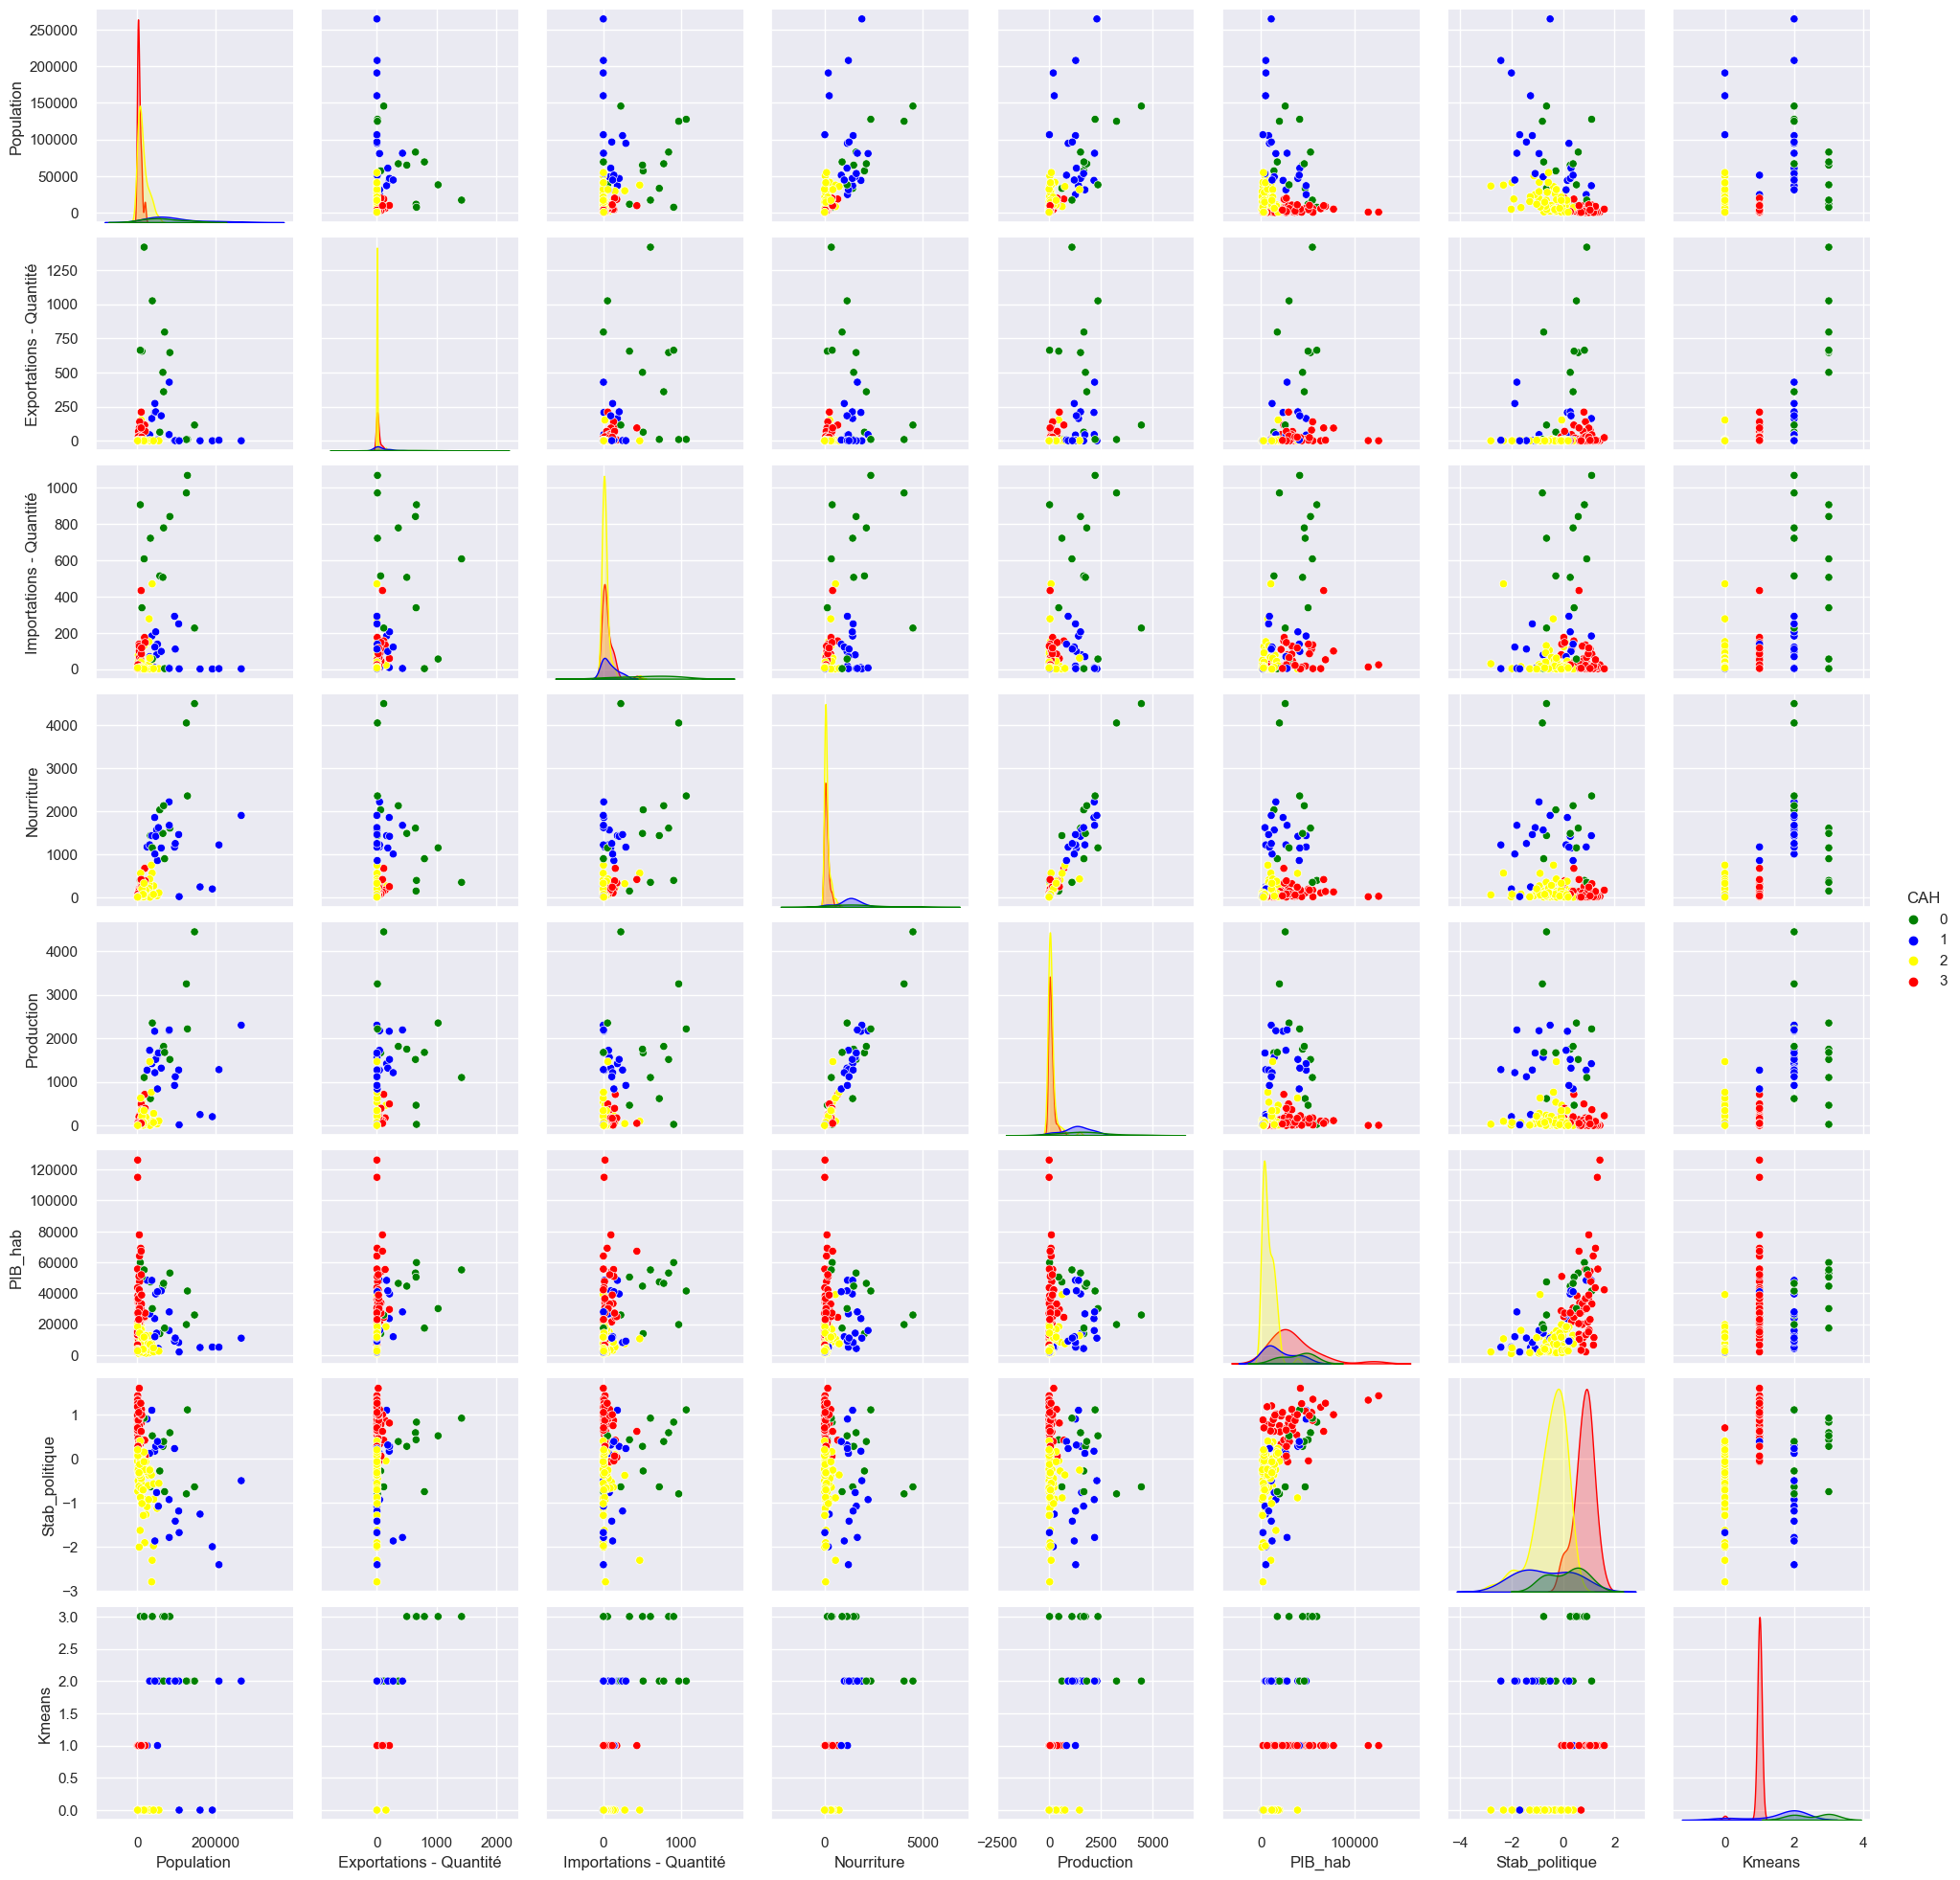

In [71]:
# Observation des clusters selon les variables

sns.pairplot(df3, hue="CAH", palette=["green", 'blue', 'yellow', "red"])

## 2) Affichage en radar des centroides

In [72]:
from sklearn.preprocessing import MinMaxScaler

In [73]:
cluster_CAH = cluster_CAH.drop('Kmeans', axis=1)
cluster_CAH

Population  Exportations - Quantité  Importations - Quantité  Nourriture  \
CAH                                                                             
0      65004.60                   482.38                   580.00     1734.46   
1      91453.92                    80.70                    78.90     1231.35   
2      13775.58                     2.94                    30.25      113.06   
3       4373.97                    24.14                    50.88      103.92   

     Production   PIB_hab  Stab_politique  
CAH                                        
0       1760.23  38856.92            0.15  
1       1319.80  19968.02           -0.67  
2        108.05   7731.48           -0.48  
3         94.96  34427.25            0.82

#### Pour pouvoir observer nos centroides et la moyenne modiale en même temps dans notre graphique radar, nous allons rajouter une ligne supplémentaire (la moyenne mondiale) à notre table des centroides

In [74]:
# Préparation de la moyenne mondiale

ajout = df3
ajout = ajout.drop(["Kmeans", "CAH"], axis=1)
ajout = pd.DataFrame(ajout.mean()).T
ajout

Population  Exportations - Quantité  Importations - Quantité  Nourriture  \
0  24583.419056                58.024845                87.217391  380.006211   

   Production       PIB_hab  Stab_politique  
0  387.838509  20221.204348       -0.041677

In [75]:
# ajout de la moyenne mondiale à nos la table des centroides

cluster_CAH = cluster_CAH.append(ajout, ignore_index=True).round(2)
cluster_CAH

Population  Exportations - Quantité  Importations - Quantité  Nourriture  \
0    65004.60                   482.38                   580.00     1734.46   
1    91453.92                    80.70                    78.90     1231.35   
2    13775.58                     2.94                    30.25      113.06   
3     4373.97                    24.14                    50.88      103.92   
4    24583.42                    58.02                    87.22      380.01   

   Production   PIB_hab  Stab_politique  
0     1760.23  38856.92            0.15  
1     1319.80  19968.02           -0.67  
2      108.05   7731.48           -0.48  
3       94.96  34427.25            0.82  
4      387.84  20221.20           -0.04

In [76]:
import plotly.graph_objects as go

In [77]:
# Mise à l'échelle des données pour la visualisation du graphique radar

minmax_scaler = MinMaxScaler(feature_range=(-3, 3))
cah_scaled = minmax_scaler.fit_transform(cluster_CAH)
cah_scaled

array([[ 1.1775837 ,  3.        ,  3.        ,  3.        ,  3.        ,
         3.        ,  0.30201342],
       [ 3.        , -2.02686468, -2.46903138,  1.14867467,  1.4131222 ,
        -0.64118226, -3.        ],
       [-2.3522084 , -3.        , -3.        , -2.96636697, -2.95283648,
        -3.        , -2.23489933],
       [-3.        , -2.73469047, -2.77484311, -3.        , -3.        ,
         2.14609978,  3.        ],
       [-1.60752446, -2.31069581, -2.37822647, -1.98405436, -1.9447477 ,
        -0.59237717, -0.46308725]])

In [78]:
categories = cluster_CAH.columns


fig = go.Figure(
    data=[
        go.Scatterpolar(r=cah_scaled[3], # <== Remplacez 0 par une valeur comprise entre 0 et 3
                        theta=categories, 
                        name='Cluster 0', 
                        fill='toself', 
                        fillcolor="indianred",
                        line_color="darkred",
                        opacity=0.4
                       ),
        go.Scatterpolar(r=cah_scaled[4], # <== La moyenne mondiale
                        theta=categories, 
                        name='Moyenne', 
                        fill='toself',
                        fillcolor="darkorange",
                        line_color="orangered",
                        opacity=0.3,)
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Comparaison des clusters'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

fig.show()

# <span style='color:blue '>V. Les outliers </span>

In [79]:
df_outliers

Population  Exportations - Quantité  \
Zone                                                          
Brésil                  207833.823                   4223.0   
Inde                   1338676.785                      4.0   
États-Unis d'Amérique   325084.756                   3692.0   

                       Importations - Quantité  Nourriture  Production  \
Zone                                                                     
Brésil                                     3.0      9982.0     14201.0   
Inde                                       0.0      2965.0      3545.0   
États-Unis d'Amérique                    123.0     18100.0     21914.0   

                       PIB_hab  Stab_politique  
Zone                                            
Brésil                 14524.6           -0.47  
Inde                    6182.9           -0.76  
États-Unis d'Amérique  59914.8            0.29